# **Titanic - Machine Learning from Disaster**

### **Steps**
1. Import and profile data
2. Transform categorical variables
3. Correlation Matrix
4. Feature Engineering, Impute, Bin Features
5. Add Interactions
6. Score Models
7. Tune Hyper Parameters - if necessary
8. Calculate Model Probabilities
9. Create Ensemble Models
10. Calculate Model Performance Metrics
11. Select Final Model
12. Submit to Kaggle
13. Compare Public Score with Leaderboard

### **Workflow**
First, **iterate** thru steps 1, 2, 3, 4, and 6 to determine:
1. To hot-encode or not.
2. To bin features or not.
3. Use fare or do a log transformation.
4. Best way to impute missing features.
5. Include Family Size or not.
6. How to group tickets and titles.

Once enough progress was made then turned to tuning the hyper parameters by **running** steps 1, 2, 3, 4, 6, 7, 8, and 10.
**SVC** emerged as the best model while the Random Forest, Decision Tree, and XGBoost all showed evidence of overfitting.

Decided to **store models in a dictionary** to make it easier to **iterate** thru models and to explore if some models 
worked better with scaled features or not.

Next, decided to explore **feature interactions (step 5)** and **iterated** thru steps 1, 2, 3, 4, 5, 6, 7, 8, and 10 to 
determine which interactions to include. Decided to focus on the features with highest importance based on the 
findings from **step 7 (hyper-parameter).**

Finally, observed that SVC is good at predicting true non survivors, but other models good at predicting survivors, 
so decided to build several ensemble models and **running** steps 1 thru 10.

**Final** model selected was and **Ensemble Model** made up of SVC and a Random Forest Model with tuned hyper-parameters.

### **Findings**
1. Categorical features performed better if they are one-hot encoded.
2. Continuous features like Fare, Age, and Family Size performed better as continuous instead of as bins.
3. Doing this results in an above median-model with a Public Score of **0.79186**.
4. Adding feature interactions provided gains, but the impact was minimal.
5. No need to iterate over hyper-parameters for further gains. Run study and settle on best parameters.
6. Adding ensemble models resulted in big improvement.

In [1]:
import pandas as pd, numpy as np, random, seaborn as sns, matplotlib.pyplot as plt, warnings, re, itertools
import matplotlib.ticker as mtick

plot_title_dict = {'fontsize': 18, 'fontweight': 'bold'}
plot_axis_dict = {'fontsize': 12, 'fontweight': 'bold'}

# Function to plot survival rate by feature
def surv_percent_fun(col_name, fig_size):    
    counts_df = train_df\
        .groupby([col_name], as_index = False)\
        .agg(Count = (col_name, 'count'))

    surv_pct_df = train_df\
        .groupby([col_name, 'Survived'], as_index = False)\
        .agg(Count = (col_name, 'count'))\
        .pivot(index = col_name, columns = 'Survived', values = 'Count')\
        .fillna(0)
    surv_pct_df['Total'] = surv_pct_df[0] + surv_pct_df[1]
    surv_pct_df[0] = surv_pct_df[0] / surv_pct_df['Total']
    surv_pct_df[1] = surv_pct_df[1] / surv_pct_df['Total']
    del surv_pct_df['Total']
    surv_pct_df = surv_pct_df[surv_pct_df.columns[::-1]]

    fig, ax = plt.subplots(figsize = fig_size)
    surv_pct_df.plot(kind = 'bar', stacked = True, color = ['lightblue', 'grey'], ax = ax)
    plt.title('Survival Rates by ' + col_name.replace('_', ' '), fontdict = plot_title_dict)
    plt.ylabel('Survival Rate', fontdict = plot_axis_dict)
    plt.xlabel(col_name.replace('_', ' ') + ' (Count)', fontdict = plot_axis_dict)
    ax.set_xticklabels([str(t) + ' (' + str(c) + ')' for t, c in zip(counts_df[col_name], counts_df['Count'])])
    ax.tick_params(axis = 'x', labelrotation = 0)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
    plt.grid(axis = 'y')
    return

# 1. Import and profile data

4 features have missing values: Cabin (1,014), Age (263), Embarked (2), Fare (1)

In [2]:
train_df = pd.read_csv('/Users/andressanchez/Documents/DataScience/Titanic/data/train.csv')
test_df = pd.read_csv('/Users/andressanchez/Documents/DataScience/Titanic/data/test.csv')
df_list = [train_df, test_df]
plot_df = train_df.copy()[['Survived', 'Age', 'Embarked', 'Pclass', 'Sex', 'SibSp', 'Parch']]

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
for df in df_list:
    df.info()
    print(' ')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df.describe(include = ['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [6]:
pd.concat([train_df, test_df]).isnull().sum().sort_values(ascending = False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
PassengerId       0
Pclass            0
Name              0
Sex               0
SibSp             0
Parch             0
Ticket            0
dtype: int64

# 2. Transform Categorical Variables

# 2.1 Ticket

1. Create ticket group based on alphabetic characters in ticket
2. Map groups only if ticket characters are in both sets
3. One hot encode ticket group
4. Feature Engineering: ticket frequency

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketIsNumeric,Ticket_Alpha,Ticket_Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,False,A/5,A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,PC,P
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,STON/O2,Ston
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,True,113803,Numeric
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,373450,Numeric


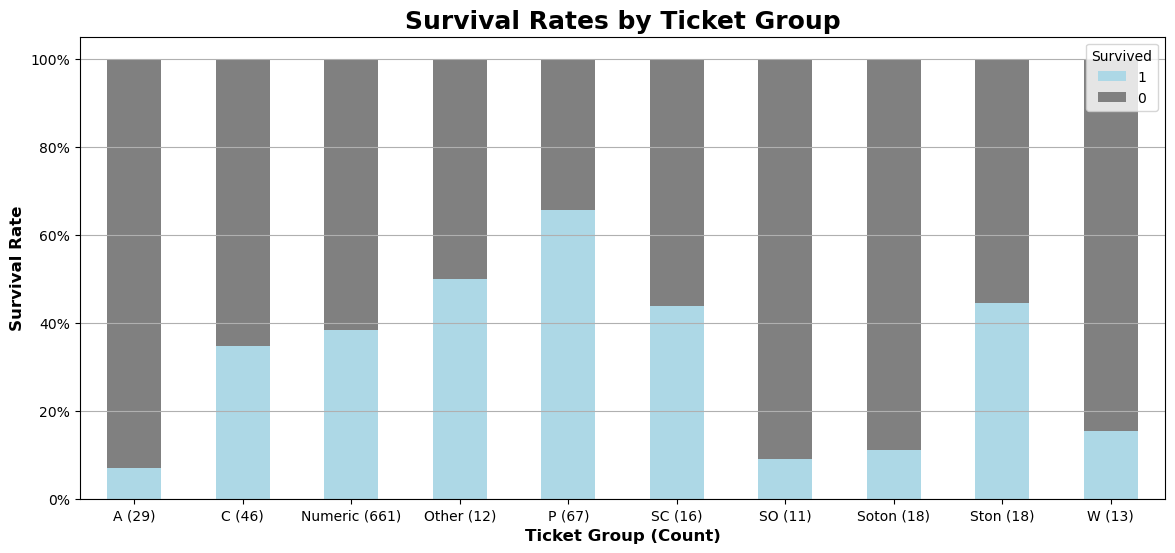

In [7]:
tickets_dict = {'A': ['A', 'A/5', 'A5', 'A/4', 'A4', 'A/S', 'AQ/3', 'AQ/4'],
                'C': ['CA', 'C'],
                'P': ['PC', 'PP', 'P/PP', 'SW/PP'],
                'SC': ['SC/PARIS', 'SC/AH', 'SC/A4', 'SC/AH BASLE', 'SC/A3', 'SCO/W'], 
                'SO': ['SOC', 'SO/PP', 'SO/C', 'SOP', 'SP'], 
                'Soton': ['SOTON/OQ', 'SOTON/O2', 'CA/SOTON'], 
                'Ston': ['STON/O', 'STON/O2', 'STON/OQ'], 
                'W': ['W/C', 'WE/P', 'WEP']}
tickets_alpha = list(itertools.chain(*[v for v in tickets_dict.values()]))

for df in df_list:
    df['TicketIsNumeric'] = [t.isnumeric() for t in df['Ticket']]    
    df['Ticket_Alpha'] = [t.upper().replace('.', '') for t in df['Ticket']]
    df['Ticket_Alpha'] = [re.sub(r' \d+', '', t) for t in df['Ticket_Alpha']]
    df['Ticket_Alpha_Group'] = ['Other' if t not in tickets_alpha else t for t in df['Ticket_Alpha']]
    df['Ticket_Group'] = 'Missing'
    df.loc[df['TicketIsNumeric'], 'Ticket_Group'] = 'Numeric'
    df.loc[df['Ticket_Group'] == 'Missing', 'Ticket_Group'] = df['Ticket_Alpha_Group']
    for d in tickets_dict:
        df['Ticket_Group'] = df['Ticket_Group'].replace(tickets_dict[d], d) 
    df.drop(['Ticket_Alpha_Group'], axis = 1, inplace = True)

surv_percent_fun('Ticket_Group', (14, 6))
train_df.head()

In [8]:
ticket_train_df = train_df[train_df['TicketIsNumeric'] == False]\
    .groupby(['Ticket_Alpha', 'Ticket_Group'], as_index = False)\
    .agg(Count = ('Ticket_Alpha', 'count'))
ticket_train_df['Set'] = 'Train'

ticket_test_df = test_df[test_df['TicketIsNumeric'] == False]\
    .groupby(['Ticket_Alpha', 'Ticket_Group'], as_index = False)\
    .agg(Count = ('Ticket_Alpha', 'count'))
ticket_test_df['Set'] = 'Test'

pd.concat([ticket_train_df, ticket_test_df])\
    .pivot(index = ['Ticket_Group', 'Ticket_Alpha'], columns = 'Set', values = 'Count')\
    .sort_values(by = ['Ticket_Group', 'Train'], ascending = False)

Set                        Test  Train
Ticket_Group Ticket_Alpha             
W            W/C            5.0   10.0
             WE/P           NaN    2.0
             WEP            1.0    1.0
Ston         STON/O         2.0   12.0
             STON/O2        1.0    6.0
             STON/OQ        1.0    NaN
Soton        SOTON/OQ       9.0   15.0
             SOTON/O2       1.0    2.0
             CA/SOTON       NaN    1.0
SO           SOC            2.0    5.0
             SO/PP          4.0    3.0
             SO/C           NaN    1.0
             SOP            NaN    1.0
             SP             NaN    1.0
SC           SC/PARIS       8.0   11.0
             SC/AH          2.0    2.0
             SC/A4          1.0    1.0
             SC/AH BASLE    NaN    1.0
             SCO/W          NaN    1.0
             SC/A3          1.0    NaN
P            PC            32.0   60.0
             PP             1.0    3.0
             P/PP           NaN    2.0
             SW/PP          NaN    2.0
Other        FCC            4.0    5.0
             LINE           NaN    4.0
             FA             NaN    1.0
             FC             2.0    1.0
             SC             1.0    1.0
             LP             1.0    NaN
C            CA            27.0   41.0
             C              3.0    5.0
A            A/5            6.0   19.0
             A/4            3.0    6.0
             A5             1.0    2.0
             A/S            NaN    1.0
             A4             NaN    1.0
             A              1.0    NaN
             AQ/3           1.0    NaN
             AQ/4           1.0    NaN

In [9]:
plot_df['Ticket_Group'] = train_df['Ticket_Group']
train_df = pd.get_dummies(train_df, columns = ['Ticket_Group'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Ticket_Group'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    df.drop(['TicketIsNumeric', 'Ticket_Alpha'], axis = 1, inplace = True)    
    for c in [c for c in df.columns if 'Ticket_Group' in c]:
        df[c] = df[c].astype(int)
    df.columns = df.columns.str.replace('Ticket_Group', 'Ticket')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_Ston,Ticket_W
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,1,0,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,1,0,0,0,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,1,0,0,0,0,0,0,0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_Ston,Ticket_W,Ticket_Freq
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,1,0,0,0,0,0,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,0,0,0,0,0,1


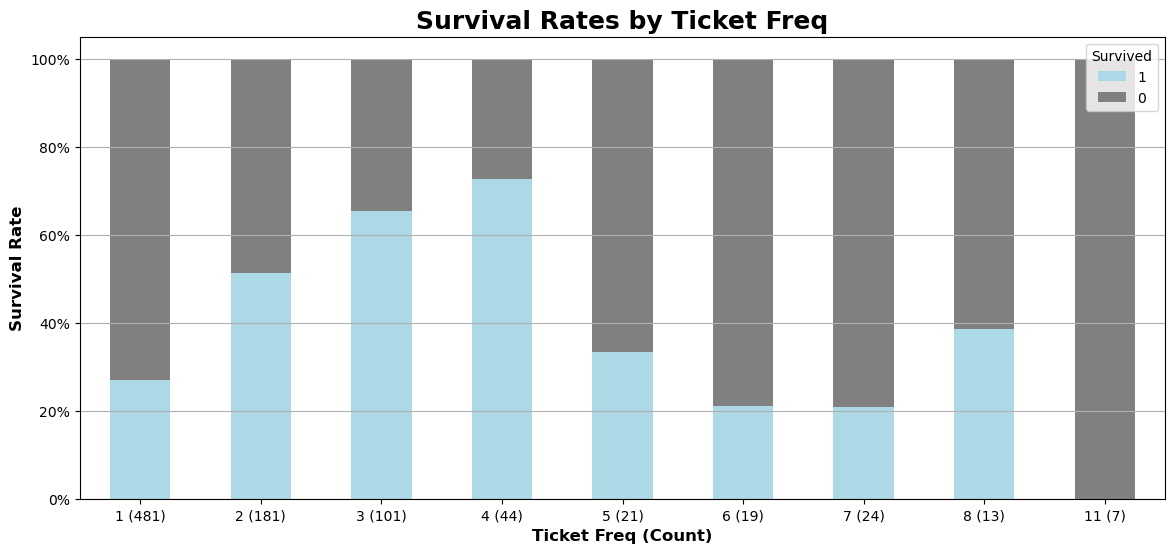

In [10]:
ticket_freq_df = pd.concat([train_df, test_df])\
        .groupby(['Ticket'], as_index = False)\
        .agg(Ticket_Freq = ('Ticket', 'count'))

for df in df_list:
    df['Ticket_Freq'] = df.merge(ticket_freq_df, on = ['Ticket'], how = 'left')['Ticket_Freq']

plot_df['Ticket_Freq'] = train_df['Ticket_Freq']

surv_percent_fun('Ticket_Freq', (14, 6))
train_df.head()

In [11]:
for df in df_list:
    df.drop(['Ticket'], axis = 1, inplace = True)

# 2.2 Name
1. Extract title from Name
2. Map titles
3. One hot encode title

In [12]:
for df in df_list:
    df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand = False)
    df.drop(['Name'], axis = 1, inplace = True)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,Ticket_Soton,Ticket_Ston,Ticket_W,Ticket_Freq,Title
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,...,0,0,0,0,0,0,0,0,1,Mr
1,2,1,1,female,38.0,1,0,71.2833,C85,C,...,0,0,1,0,0,0,0,0,2,Mrs
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,...,0,0,0,0,0,0,1,0,1,Miss
3,4,1,1,female,35.0,1,0,53.1000,C123,S,...,1,0,0,0,0,0,0,0,2,Mrs
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,...,1,0,0,0,0,0,0,0,1,Mr


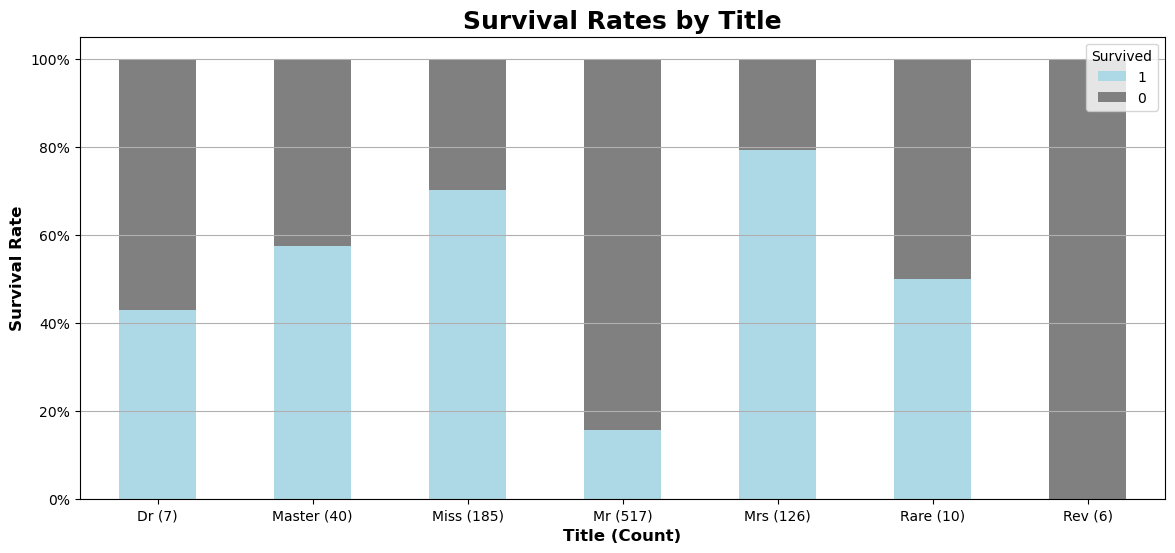

In [13]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Major', 'Sir', 'Jonkheer', 'Dona']

for df in df_list:
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
plot_df['Title'] = train_df['Title'] 

surv_percent_fun('Title', (14, 6))
train_df.head()

In [14]:
plot_df['Title'] = train_df['Title']
train_df = pd.get_dummies(train_df, columns = ['Title'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Title'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Title' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,...,Ticket_Ston,Ticket_W,Ticket_Freq,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev
0,1,0,3,male,22.0,1,0,7.2500,NaN,S,...,0,0,1,0,0,0,1,0,0,0
1,2,1,1,female,38.0,1,0,71.2833,C85,C,...,0,0,2,0,0,0,0,1,0,0
2,3,1,3,female,26.0,0,0,7.9250,NaN,S,...,1,0,1,0,0,1,0,0,0,0
3,4,1,1,female,35.0,1,0,53.1000,C123,S,...,0,0,2,0,0,0,0,1,0,0
4,5,0,3,male,35.0,0,0,8.0500,NaN,S,...,0,0,1,0,0,0,1,0,0,0


# 2.2 Sex
1. One hot encode sex

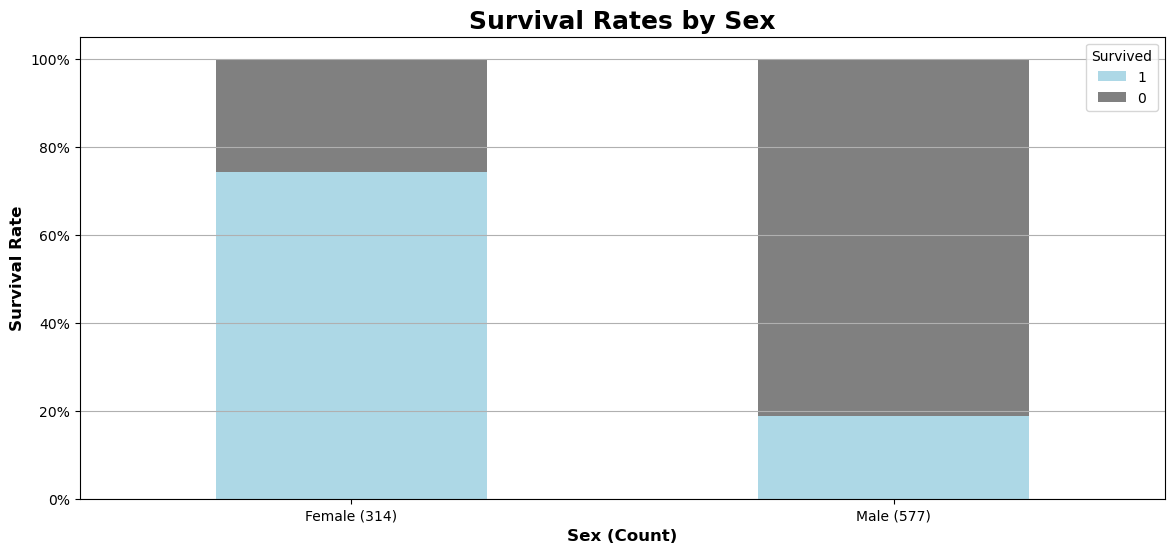

In [15]:
for df in df_list:
    df['Sex'] = df['Sex'].str.title()

surv_percent_fun('Sex', (14, 6))

In [16]:
plot_df['Sex'] = train_df['Sex']
train_df = pd.get_dummies(train_df, columns = ['Sex'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Sex'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Sex' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_A,...,Ticket_Freq,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male
0,1,0,3,22.0,1,0,7.2500,NaN,S,1,...,1,0,0,0,1,0,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,C85,C,0,...,2,0,0,0,0,1,0,0,1,0
2,3,1,3,26.0,0,0,7.9250,NaN,S,0,...,1,0,0,1,0,0,0,0,1,0
3,4,1,1,35.0,1,0,53.1000,C123,S,0,...,2,0,0,0,0,1,0,0,1,0
4,5,0,3,35.0,0,0,8.0500,NaN,S,0,...,1,0,0,0,1,0,0,0,0,1


# 2.3 Port of Embarkation
1. Impute missing with most frequent
2. Add Missing Port Indicator
3. One hot encode Embarked

Most frequent port is S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Embarked,Ticket_A,...,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male,Embarked_Missing
0,1,0,3,22.0,1,0,7.2500,NaN,S,1,...,0,0,0,1,0,0,0,0,1,0
1,2,1,1,38.0,1,0,71.2833,C85,C,0,...,0,0,0,0,1,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,NaN,S,0,...,0,0,1,0,0,0,0,1,0,0
3,4,1,1,35.0,1,0,53.1000,C123,S,0,...,0,0,0,0,1,0,0,1,0,0
4,5,0,3,35.0,0,0,8.0500,NaN,S,0,...,0,0,0,1,0,0,0,0,1,0


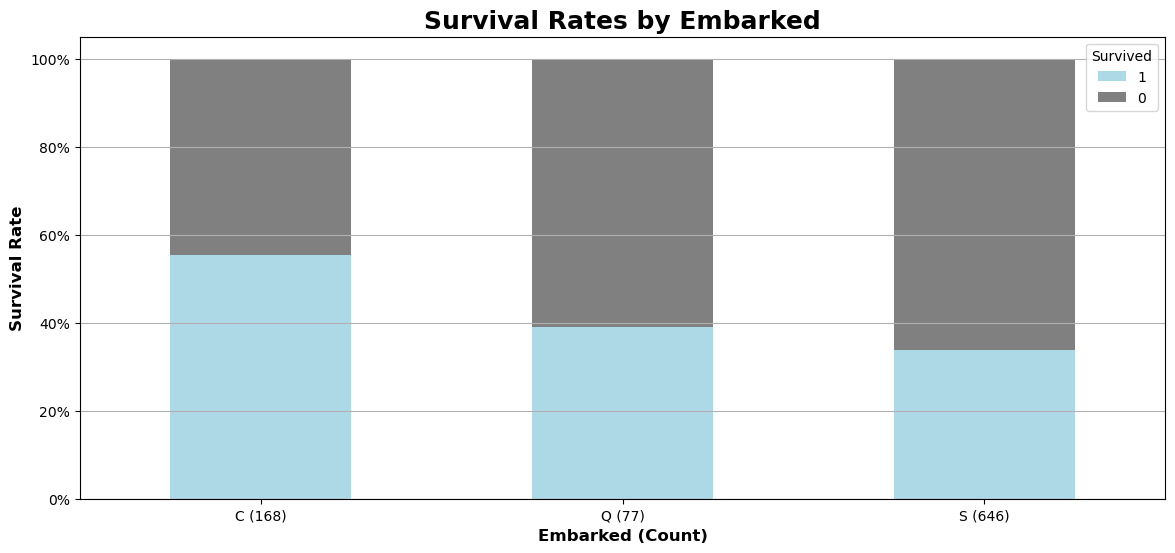

In [17]:
freq_port = train_df.Embarked.dropna().mode()[0]
print('Most frequent port is ' + freq_port)

for df in df_list:
    df.loc[df['Embarked'].isnull(), 'Embarked_Missing'] = 1
    df['Embarked_Missing'] = df['Embarked_Missing'].fillna(0).astype(int)
    df['Embarked'] = df['Embarked'].fillna(freq_port)

surv_percent_fun('Embarked', (14, 6))
train_df.head()

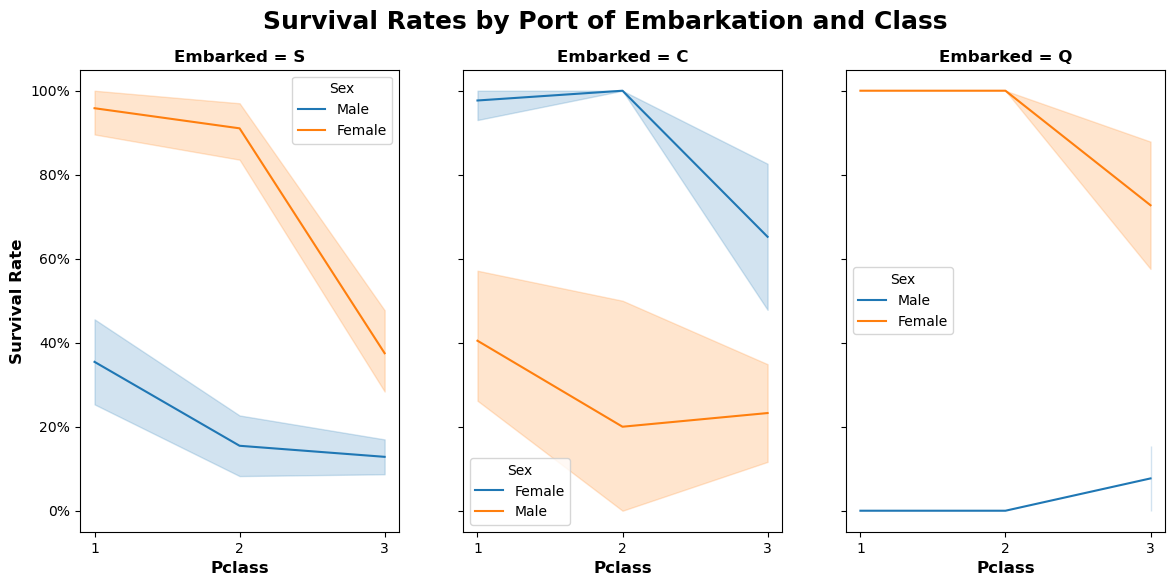

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, figsize = (14, 6))

for poe, ax in zip(['S', 'C', 'Q'], [ax1, ax2, ax3]):
    sns.lineplot(x = 'Pclass', y = 'Survived', hue = 'Sex',
                 data = plot_df[plot_df['Embarked'] == poe], ax = ax)
    ax.set_xlabel('Pclass', fontdict = plot_axis_dict)
    ax.set_title("Embarked = " + poe, fontdict = plot_axis_dict)
    ax.locator_params(axis = 'x', nbins = 3)
ax1.set_ylabel('Survival Rate', fontdict = plot_axis_dict)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.suptitle('Survival Rates by Port of Embarkation and Class', 
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.show()

In [19]:
plot_df['Embarked'] = train_df['Embarked']
train_df = pd.get_dummies(train_df, columns = ['Embarked'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Embarked'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Embarked' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,...,Title_Mr,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,22.0,1,0,7.2500,NaN,1,0,...,1,0,0,0,0,1,0,0,0,1
1,2,1,1,38.0,1,0,71.2833,C85,0,0,...,0,1,0,0,1,0,0,1,0,0
2,3,1,3,26.0,0,0,7.9250,NaN,0,0,...,0,0,0,0,1,0,0,0,0,1
3,4,1,1,35.0,1,0,53.1000,C123,0,0,...,0,1,0,0,1,0,0,0,0,1
4,5,0,3,35.0,0,0,8.0500,NaN,0,0,...,1,0,0,0,0,1,0,0,0,1


# 3. Correlation Matrix

Decided to wait after hot encoding to better understand how to impute missing features.

Features with missing values:
1. **Age:** Correlated with Class and Titles (Master, Miss, Mr, Mrs, and Rare)
2. **Fare:** Correlated with Class, Port of Embarkation, and Ticket (P)

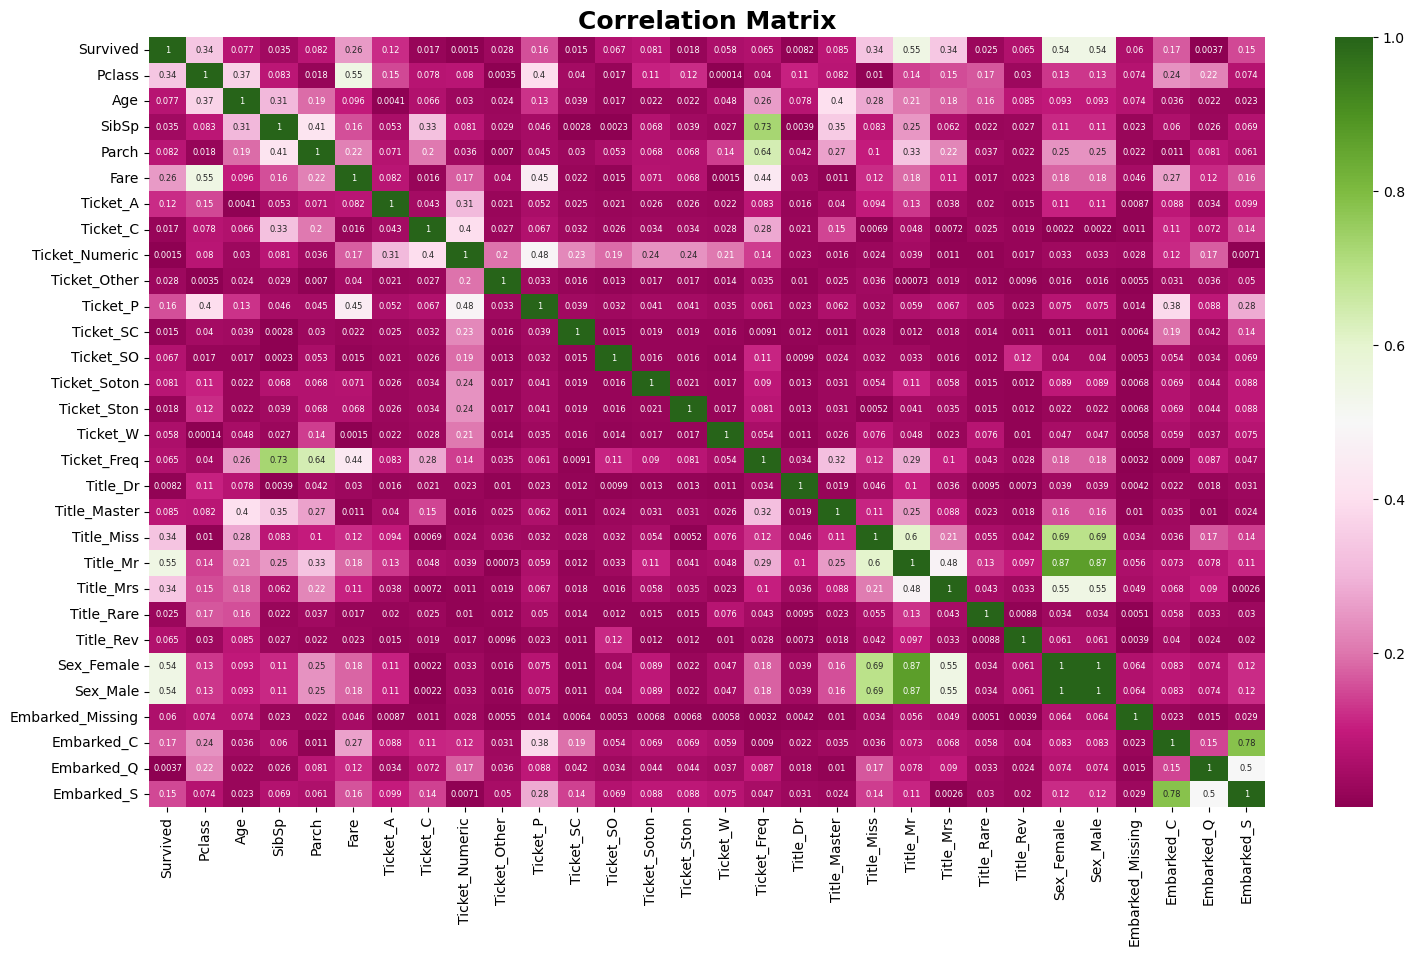

In [20]:
f, ax = plt.subplots(figsize = (18, 10))
corr_df = train_df.drop('PassengerId', axis = 1).corr(numeric_only = True).abs()
sns.heatmap(corr_df, cmap = "PiYG", annot = True, annot_kws = {"fontsize": 6})
plt.title('Correlation Matrix', fontdict = plot_title_dict)
plt.show()

# 4. Feature Engineering, Impute, Bin Features

# 4.1 Age
1. Correlated with Class and Titles (Master, Miss, Mr, Mrs, and Rare)
2. Impute based on correlation
3. Add indicator for missing ages
4. Bin Ages if model perfoms better

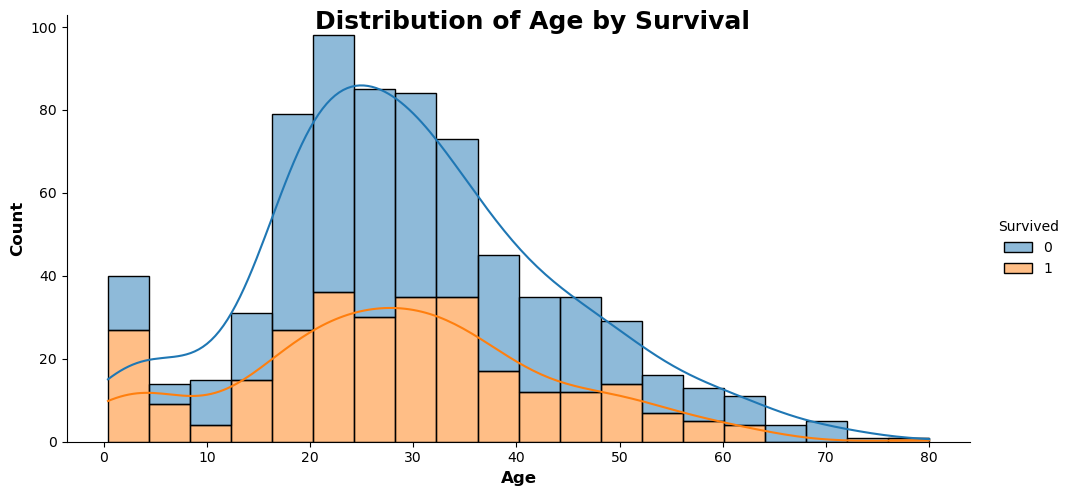

In [21]:
sns.displot(data = train_df, 
            x = 'Age', 
            hue = 'Survived', 
            kde = True,
            height = 5,
            aspect = 2,
            multiple = 'stack')
plt.suptitle('Distribution of Age by Survival',
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.ylabel('Count', fontdict = plot_axis_dict)
plt.xlabel('Age', fontdict = plot_axis_dict)
plt.show()

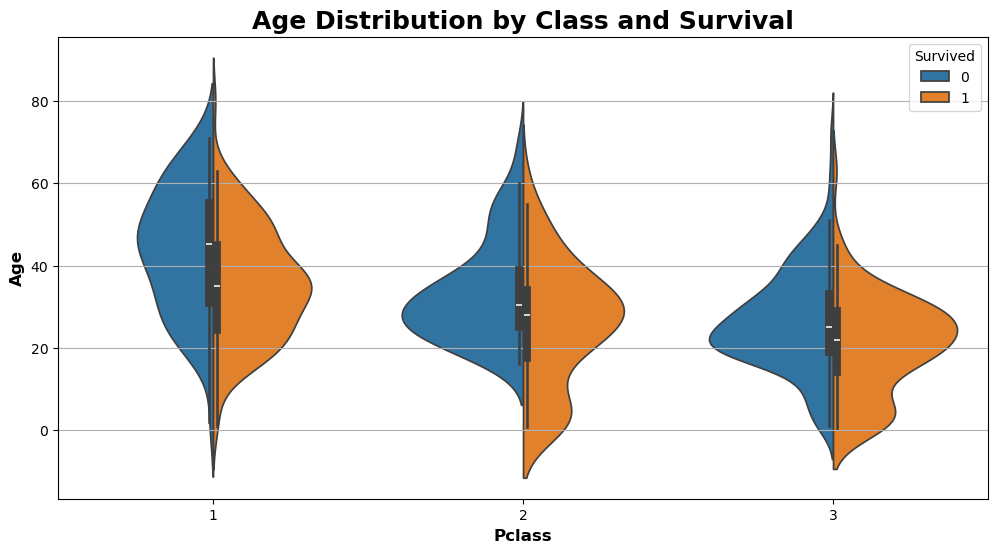

In [22]:
f, ax = plt.subplots(figsize = (12, 6))
sns.violinplot(data = plot_df, x = "Pclass", y = "Age", hue = "Survived", split = True, ax = ax)
ax.set_title('Age Distribution by Class and Survival', fontdict = plot_title_dict)
plt.ylabel('Age', fontdict = plot_axis_dict)
plt.xlabel('Pclass', fontdict = plot_axis_dict)
plt.grid(axis = 'y')
plt.show()

In [23]:
missing_age_cols = ['Pclass', 'Title_Master', 'Title_Mr', 'Title_Mrs', 'Title_Miss', 'Title_Rare']
age_missing_df = train_df[missing_age_cols + ['Age']]\
    .dropna()\
    .groupby(missing_age_cols, as_index = False)\
    .median()
age_missing_df.columns = age_missing_df.columns.str.replace('Age', 'Age_Median')
age_missing_df['Age_Median'] = age_missing_df['Age_Median'].astype(int)

age_missing_df

,Pclass,Title_Master,Title_Mr,Title_Mrs,Title_Miss,Title_Rare,Age_Median
0,1,0,0,0,0,0,46
1,1,0,0,0,0,1,48
2,1,0,0,0,1,0,30
3,1,0,0,1,0,0,40
4,1,0,1,0,0,0,40
5,1,1,0,0,0,0,4
6,2,0,0,0,0,0,46
7,2,0,0,0,1,0,24
8,2,0,0,1,0,0,32
9,2,0,1,0,0,0,31


In [24]:
for df in df_list:
    df.loc[df['Age'].isnull(), 'Age_Missing'] = 1
    df['Age_Missing'] = df['Age_Missing'].fillna(0).astype(int)
    df['Age_Median'] = df.merge(age_missing_df, on = missing_age_cols, how = 'left')['Age_Median']
    df.loc[df['Age'].isnull(), 'Age'] = df['Age_Median']
    df.drop(['Age_Median'], axis = 1, inplace = True)
    df['Age'] = df['Age'].astype(int)
plot_df['Age'] = train_df['Age']

train_df.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,...,Title_Mrs,Title_Rare,Title_Rev,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing
0,1,0,3,22,1,0,7.2500,NaN,1,0,...,0,0,0,0,1,0,0,0,1,0
1,2,1,1,38,1,0,71.2833,C85,0,0,...,1,0,0,1,0,0,1,0,0,0
2,3,1,3,26,0,0,7.9250,NaN,0,0,...,0,0,0,1,0,0,0,0,1,0
3,4,1,1,35,1,0,53.1000,C123,0,0,...,1,0,0,1,0,0,0,0,1,0
4,5,0,3,35,0,0,8.0500,NaN,0,0,...,0,0,0,0,1,0,0,0,1,0


In [25]:
# num_bins = 9
# train_df['Age_Interval'] = pd.qcut(train_df['Age'], num_bins)

# age_int_df = train_df\
#     .groupby(['Age_Interval'], as_index = False)\
#     .agg(Survived = ('Survived', 'mean'),
#          Count = ('Age_Interval', 'count'))
# age_int_df['Age'] = range(num_bins)

# fig, axs = plt.subplots(figsize = (22, 9))
# sns.countplot(x = 'Age_Interval', hue = 'Survived', data = train_df)
# plt.title('Distribution of Passengers By Age Interval and Survival')
# plt.show()

# age_int_df

In [26]:
# for df in df_list:
#     df['Age'] = [[b for i, b in zip(age_int_df['Age_Interval'], age_int_df['Age']) if a in i][0] for a in df['Age']]
# train_df.drop(['Age_Interval'], axis = 1, inplace = True)

# train_df.head()

# 4.2 Passenger Class
1. One hot encode pclass

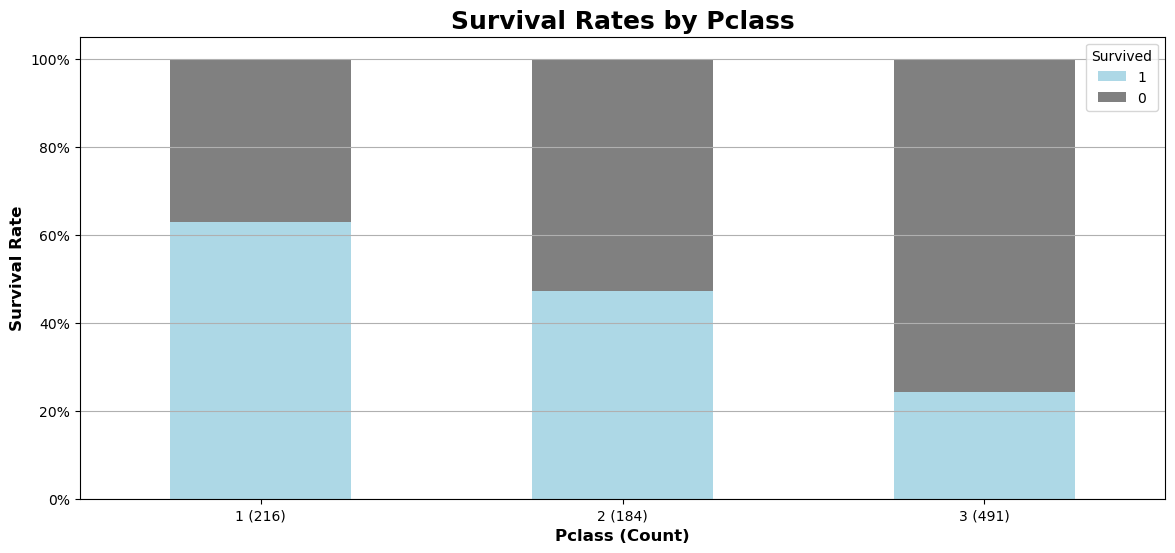

In [27]:
surv_percent_fun('Pclass', (14, 6))

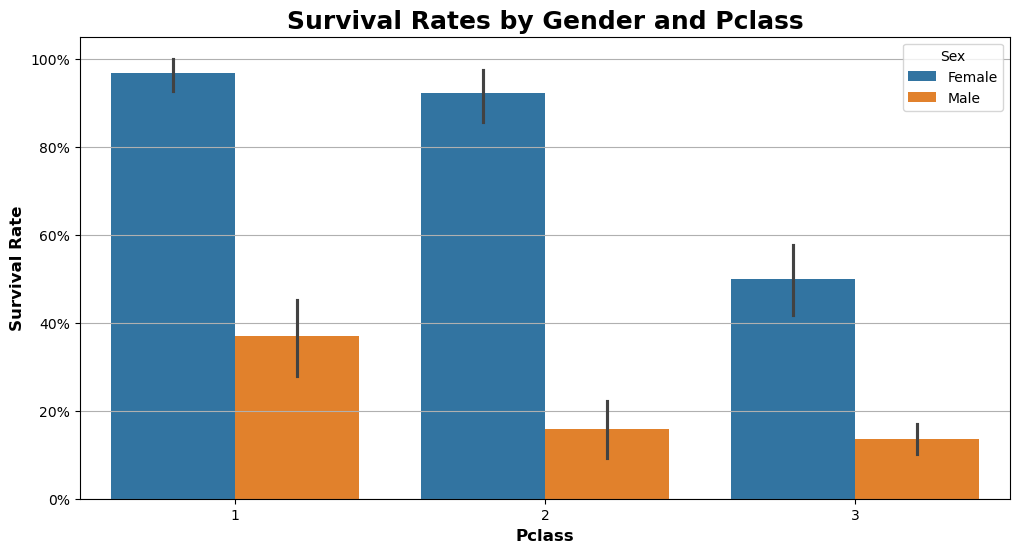

In [28]:
f, ax = plt.subplots(figsize = (12, 6))
sns.barplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = plot_df)
plt.title('Survival Rates by Gender and Pclass', fontdict = plot_title_dict)
plt.ylabel('Survival Rate', fontdict = plot_axis_dict)
plt.xlabel('Pclass', fontdict = plot_axis_dict)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.grid(axis = 'y')
plt.show()

In [29]:
train_df = pd.get_dummies(train_df, columns = ['Pclass'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Pclass'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Pclass' in c]:
        df[c] = df[c].astype(int)

train_df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,...,Sex_Female,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3
0,1,0,22,1,0,7.2500,NaN,1,0,0,...,0,1,0,0,0,1,0,0,0,1
1,2,1,38,1,0,71.2833,C85,0,0,0,...,1,0,0,1,0,0,0,1,0,0
2,3,1,26,0,0,7.9250,NaN,0,0,0,...,1,0,0,0,0,1,0,0,0,1
3,4,1,35,1,0,53.1000,C123,0,0,1,...,1,0,0,0,0,1,0,1,0,0
4,5,0,35,0,0,8.0500,NaN,0,0,1,...,0,1,0,0,0,1,0,0,0,1


# 4.3 Fare
1. Correlated with Class, Port of Embarkation, and Ticket (P)
2. Impute based on correlation
3. Add indicator for missing fare
4. Bin Fares if model perfoms better

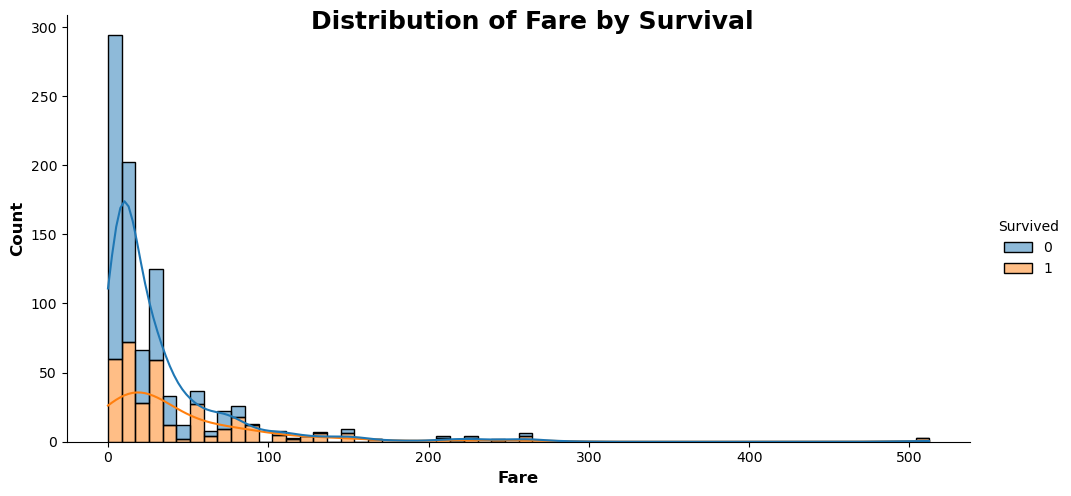

In [30]:
sns.displot(data = train_df, 
            x = 'Fare', 
            hue = 'Survived', 
            kde = True,
            height = 5,
            aspect = 2,
            multiple = 'stack')
plt.suptitle('Distribution of Fare by Survival',
             fontsize = plot_title_dict['fontsize'],
             fontweight = plot_title_dict['fontweight'])
plt.ylabel('Count', fontdict = plot_axis_dict)
plt.xlabel('Fare', fontdict = plot_axis_dict)
plt.show()

In [31]:
missing_fare_cols = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Ticket_P']
fare_missing_df = train_df[missing_fare_cols + ['Fare']]\
    .dropna()\
    .groupby(missing_fare_cols, as_index = False)\
    .median()
fare_missing_df.columns = fare_missing_df.columns.str.replace('Fare', 'Fare_Median')

fare_missing_df

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Ticket_P,Fare_Median
0,0,0,1,0,0,1,0,8.0500
1,0,0,1,0,0,1,1,16.7000
2,0,0,1,0,1,0,0,7.7500
3,0,0,1,1,0,0,0,7.8958
4,0,1,0,0,0,1,0,13.7500
5,0,1,0,0,0,1,1,10.5000
6,0,1,0,0,1,0,0,12.3500
7,0,1,0,1,0,0,0,27.7208
8,0,1,0,1,0,0,1,24.0000
9,1,0,0,0,0,1,0,52.5542


In [32]:
for df in df_list:
    df.loc[df['Fare'].isnull(), 'Fare_Missing'] = 1
    df['Fare_Missing'] = df['Fare_Missing'].fillna(0).astype(int)
    df['Fare_Median'] = df.merge(fare_missing_df, on = missing_fare_cols, how = 'left')['Fare_Median']
    df.loc[df['Fare'].isnull(), 'Fare'] = df['Fare_Median']
    df.drop(['Fare_Median'], axis = 1, inplace = True)

plot_df['Fare'] = train_df['Fare']

train_df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,...,Sex_Male,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3,Fare_Missing
0,1,0,22,1,0,7.2500,NaN,1,0,0,...,1,0,0,0,1,0,0,0,1,0
1,2,1,38,1,0,71.2833,C85,0,0,0,...,0,0,1,0,0,0,1,0,0,0
2,3,1,26,0,0,7.9250,NaN,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,1,35,1,0,53.1000,C123,0,0,1,...,0,0,0,0,1,0,1,0,0,0
4,5,0,35,0,0,8.0500,NaN,0,0,1,...,1,0,0,0,1,0,0,0,1,0


In [33]:
# for df in df_list:
#     df['Fare_Log'] = np.log(df['Fare'])
#     df.loc[df['Fare_Log'].isin([np.inf, -np.inf]), 'Fare_Log'] = 0
#     df.drop(['Fare'], axis = 1, inplace = True)

# plot_df['Fare_Log'] = train_df['Fare_Log']

# train_df.head()

In [34]:
# sns.displot(data = train_df, 
#             x = 'Fare_Log', 
#             hue = 'Survived', 
#             kde = True,
#             height = 5,
#             aspect = 2,
#             multiple = 'stack')
# plt.suptitle('Distribution of Fare (Log) by Survival')
# plt.show()

In [35]:
# num_bins = 10
# train_df['Fare_Interval'] = pd.qcut(train_df['Fare'], num_bins, precision = 4)

# fare_int_df = train_df\
#     .groupby(['Fare_Interval'], as_index = False)\
#     .agg(Survived = ('Survived', 'mean'),
#          Count = ('Fare_Interval', 'count'))
# fare_int_df['Fare'] = range(num_bins)

# fig, axs = plt.subplots(figsize = (22, 9))
# sns.countplot(x = 'Fare_Interval', hue = 'Survived', data = train_df)
# plt.title('Distribution of Passengers By Fare Interval and Survival')
# plt.show()

# fare_int_df

In [36]:
# for df in df_list:
#     df['Fare'] = [[b for i, b in zip(fare_int_df['Fare_Interval'], fare_int_df['Fare']) if a in i][0] for a in df['Fare']]
# train_df.drop(['Fare_Interval'], axis = 1, inplace = True)

# train_df.head()

# 4.4 Family Size = SibSp + Parch
1. Create Family Size
2. Drop SibSp, and Parch
3. Bin Fares if model perfoms better

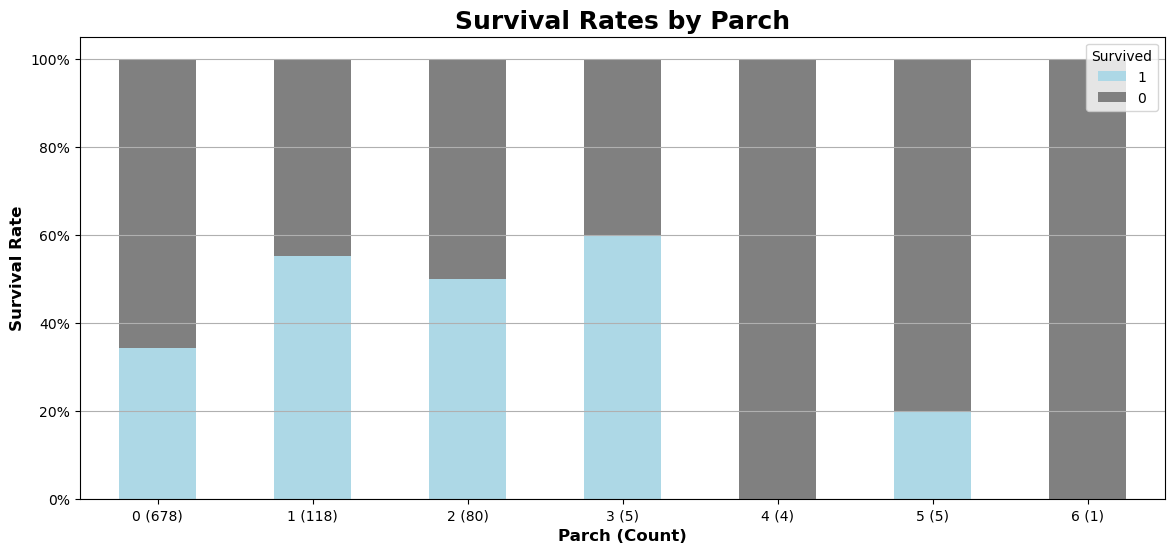

In [37]:
surv_percent_fun('Parch', (14, 6))

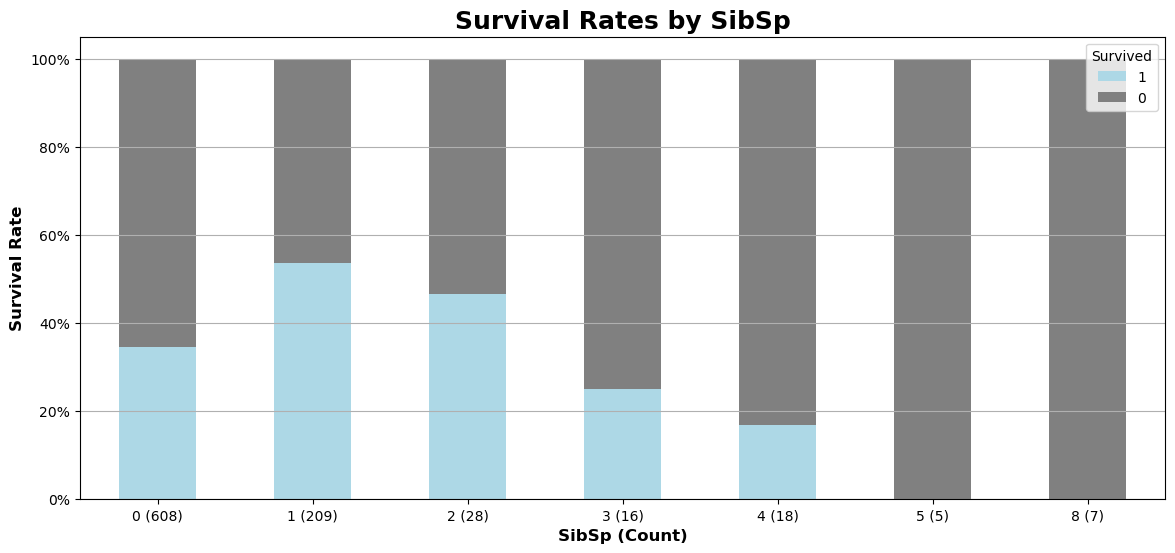

In [38]:
surv_percent_fun('SibSp', (14, 6))

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Embarked_Missing,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3,Fare_Missing,FamilySize
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,2
1,2,1,38,71.2833,C85,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,2
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,4,1,35,53.1000,C123,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,2
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1


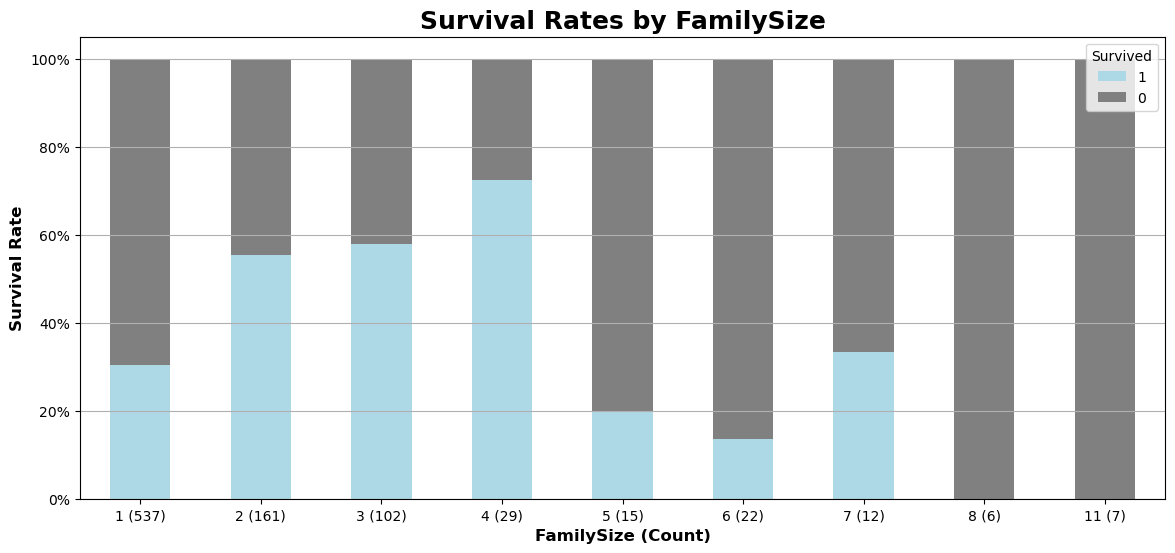

In [39]:
for df in df_list:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df.drop(['Parch', 'SibSp'], axis = 1, inplace = True)

plot_df['FamilySize'] = train_df['FamilySize']

surv_percent_fun('FamilySize', (14, 6))
train_df.head()

In [40]:
# for df in df_list:    
#     df.loc[ df['FamilySize'] <= 1, 'FamilySizeBin'] = 'Alone'
#     df.loc[(df['FamilySize'] > 1) & (df['FamilySize'] <= 4), 'FamilySizeBin'] = 'Small'
#     df.loc[(df['FamilySize'] > 4) & (df['FamilySize'] <= 6), 'FamilySizeBin'] = 'Medium'
#     df.loc[df['FamilySize'] > 6, 'FamilySizeBin'] = 'Large'
#     df.drop(['FamilySize'], axis = 1, inplace = True)
    
# train_df.head()

In [41]:
# f, ax = plt.subplots(figsize = (12, 6))
# sns.barplot(x = 'FamilySizeBin', y = 'Survived', data = train_df)
# plt.title('Survival Rates by Family Size')
# plt.show()

In [42]:
# train_df = pd.get_dummies(train_df, columns = ['FamilySizeBin'], drop_first = False)
# test_df = pd.get_dummies(test_df, columns = ['FamilySizeBin'], drop_first = False)
# df_list = [train_df, test_df]

# for df in df_list:
#     for c in [c for c in df.columns if 'FamilySizeBin' in c]:
#         df[c] = df[c].astype(int)
#     df.columns = df.columns.str.replace('FamilySizeBin', 'Fam_Size')

# train_df.head()

# 4.5 Cabin
1. Extract Deck from Cabin: First Cabin letter is the Deck
2. Do not impute missing cabin; group together as Deck X
3. Drop Cabin

,PassengerId,Survived,Age,Fare,Cabin,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,...,Embarked_C,Embarked_Q,Embarked_S,Age_Missing,Pclass_1,Pclass_2,Pclass_3,Fare_Missing,FamilySize,Deck
0,1,0,22,7.2500,NaN,1,0,0,0,0,...,0,0,1,0,0,0,1,0,2,X
1,2,1,38,71.2833,C85,0,0,0,0,1,...,1,0,0,0,1,0,0,0,2,C
2,3,1,26,7.9250,NaN,0,0,0,0,0,...,0,0,1,0,0,0,1,0,1,X
3,4,1,35,53.1000,C123,0,0,1,0,0,...,0,0,1,0,1,0,0,0,2,C
4,5,0,35,8.0500,NaN,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,X


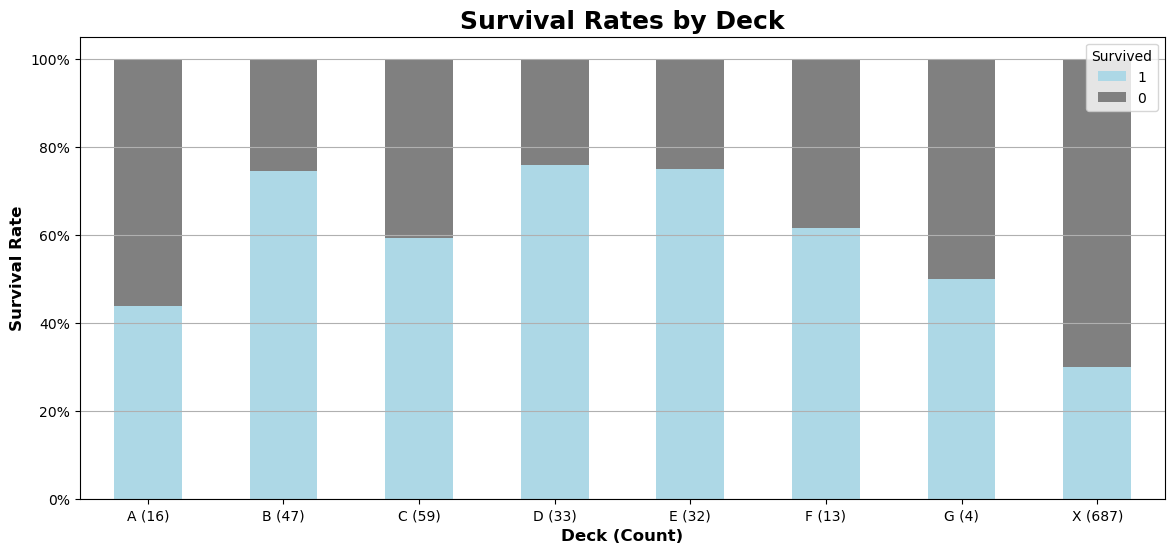

In [43]:
for df in df_list:
    df['Deck'] = [re.sub(r'\d+', '', c.split()[0])for c in df['Cabin'].fillna('X')]
    df.loc[df['Deck'] == 'T', 'Deck'] = 'A'

surv_percent_fun('Deck', (14, 6))
train_df.head()

In [44]:
plot_df['Deck'] = train_df['Deck']
train_df = pd.get_dummies(train_df, columns = ['Deck'], drop_first = False)
test_df = pd.get_dummies(test_df, columns = ['Deck'], drop_first = False)
df_list = [train_df, test_df]

for df in df_list:
    for c in [c for c in df.columns if 'Deck' in c]:
        df[c] = df[c].astype(int)
    df.drop(['Cabin'], axis = 1, inplace = True)

train_df.head()

,PassengerId,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,...,Fare_Missing,FamilySize,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
0,1,0,22,7.2500,1,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
1,2,1,38,71.2833,0,0,0,0,1,0,...,0,2,0,0,1,0,0,0,0,0
2,3,1,26,7.9250,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,4,1,35,53.1000,0,0,1,0,0,0,...,0,2,0,0,1,0,0,0,0,0
4,5,0,35,8.0500,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# 4.6 Passenger ID
1. Drop from training set

In [45]:
train_df.drop(['PassengerId'], axis = 1, inplace = True)

train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Fare_Missing,FamilySize,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X
0,0,22,7.2500,1,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,1
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,2,0,0,1,0,0,0,0,0
2,1,26,7.9250,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
4,0,35,8.0500,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# 5. Add Interactions

Explore interactions between Fare, Age, and Family Size

In [46]:
for df in df_list:
    # df['FS*Fare'] = df['FamilySize'] * df['Fare']
    # df['FS*Age'] = df['FamilySize'] * df['Age']
    df['Female*Age'] = df['Sex_Female'] * df['Age']
    df['Male*Fare'] = df['Sex_Male'] * df['Fare']
    df['Fare*Age'] = df['Fare'] * df['Age']
    
train_df.head()

,Survived,Age,Fare,Ticket_A,Ticket_C,Ticket_Numeric,Ticket_Other,Ticket_P,Ticket_SC,Ticket_SO,...,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_X,Female*Age,Male*Fare,Fare*Age
0,0,22,7.2500,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7.25,159.5000
1,1,38,71.2833,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,38,0.00,2708.7654
2,1,26,7.9250,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,26,0.00,206.0500
3,1,35,53.1000,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,35,0.00,1858.5000
4,0,35,8.0500,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,8.05,281.7500


# 6. Score Models
1. Final check for missing features
2. Scale features
3. Train candidate models and store in dictionary
4. Rank candidate models by cross-validated accuracy 

**Candidate Models:**
1. Logistic Regression
2. Support Vector Machines
3. KNN
4. Naive Bayes
5. Perceptron
6. Linear SVC
7. Stochastic Gradient Decent
8. Decision Tree
9. Random Forest

In [52]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
from xgboost import XGBClassifier

In [48]:
pd.concat([train_df, test_df]).isnull().sum().sort_values(ascending = False)

PassengerId         891
Survived            418
Fare                  0
Deck_B                0
Embarked_S            0
Age_Missing           0
Pclass_1              0
Pclass_2              0
Pclass_3              0
Fare_Missing          0
FamilySize            0
Deck_A                0
Deck_C                0
Embarked_C            0
Deck_D                0
Deck_E                0
Deck_F                0
Deck_G                0
Deck_X                0
Female*Age            0
Male*Fare             0
Fare*Age              0
Embarked_Q            0
Embarked_Missing      0
Ticket_A              0
Ticket_W              0
Ticket_C              0
Ticket_Numeric        0
Ticket_Other          0
Ticket_P              0
Ticket_SC             0
Ticket_SO             0
Ticket_Soton          0
Ticket_Ston           0
Ticket_Freq           0
Age                   0
Title_Dr              0
Title_Master          0
Title_Miss            0
Title_Mr              0
Title_Mrs             0
Title_Rare      

In [49]:
# Split X, Y
X_train = train_df.drop("Survived", axis = 1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis = 1).copy()

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [65]:
logreg = LogisticRegression()
svc = SVC(probability = True)
knn = KNeighborsClassifier(n_neighbors = 3)
gaussian = GaussianNB()
perceptron = Perceptron()
linear_svc = LinearSVC()
sgd = SGDClassifier()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier(n_estimators = 100)
xgb_boost = XGBClassifier(n_estimators = 100)

model_dict = {'Logistic Regression': {'Model': logreg, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Support Vector Machines': {'Model': svc, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'KNN': {'Model': knn, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Naive Bayes': {'Model': gaussian, 'X_Train': X_train, 'X_Test': X_test},
              'Perceptron': {'Model': perceptron, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Linear SVC': {'Model': linear_svc, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Stochastic Gradient Decent': {'Model': sgd, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'Decision Tree': {'Model': decision_tree, 'X_Train': X_train, 'X_Test': X_test},
              'Random Forest': {'Model': random_forest, 'X_Train': X_train_scaled, 'X_Test': X_test_scaled},
              'XGBoost': {'Model': xgb_boost, 'X_Train': X_train, 'X_Test': X_test}}

In [66]:
models_df = pd.DataFrame()

for d in model_dict:
    print('Training ' + d)
    
    # Fit Models
    model_dict[d]['Model'].fit(model_dict[d]['X_Train'], Y_train)
    
    # Store Probabilities (not all models support predict_proba)
    # Only need this in case model is later included in ensemble
    if d in ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Naive Bayes', 
             'Decision Tree', 'Random Forest', 'XGBoost']:
        model_dict[d]['CV_Prob'] = cross_val_predict(model_dict[d]['Model'],
                                                     model_dict[d]['X_Train'],
                                                     Y_train,
                                                     cv = 10,
                                                     method = 'predict_proba')[:,1]
        model_dict[d]['Train_Prob'] = model_dict[d]['Model'].predict_proba(model_dict[d]['X_Train'])[:,1]
        model_dict[d]['Test_Prob'] = model_dict[d]['Model'].predict_proba(model_dict[d]['X_Test'])[:,1]
    
    # Calculate CV Accuracy and AUC
    cv_scores_acc = cross_val_score(model_dict[d]['Model'], 
                                    model_dict[d]['X_Train'],
                                    Y_train, 
                                    cv = 10, 
                                    scoring = "accuracy")
    cv_scores_auc = cross_val_score(model_dict[d]['Model'], 
                                    model_dict[d]['X_Train'],
                                    Y_train, 
                                    cv = 10, 
                                    scoring = "roc_auc")
    model_score = model_dict[d]['Model'].score(model_dict[d]['X_Train'], Y_train)

    # Append metrics
    df = pd.DataFrame({'Model': [d],
                       'Score': [round(model_score * 100, 2)],
                       'CV_Accuracy_Mean': [round(cv_scores_acc.mean() * 100, 2)],
                       'CV_Accuracy_SD': [round(cv_scores_acc.std() * 100, 2)],
                       'CV_ROC_AUC_Mean': [round(cv_scores_auc.mean() * 100, 2)],
                       'CV_ROC_AUC_SD': [round(cv_scores_auc.std() * 100, 2)]})
    models_df = pd.concat([models_df, df]).reset_index(drop = True)

models_df.sort_values(by = 'CV_Accuracy_Mean', ascending = False)

Training Logistic Regression
Training Support Vector Machines
Training KNN
Training Naive Bayes
Training Perceptron
Training Linear SVC
Training Stochastic Gradient Decent
Training Decision Tree
Training Random Forest
Training XGBoost


,Model,Score,CV_Accuracy_Mean,CV_Accuracy_SD,CV_ROC_AUC_Mean,CV_ROC_AUC_SD
1,Support Vector Machines,87.09,83.39,3.23,86.88,6.15
0,Logistic Regression,84.51,83.17,3.20,86.87,5.09
5,Linear SVC,84.40,83.05,3.49,86.70,5.12
8,Random Forest,99.21,82.83,4.96,87.34,6.06
9,XGBoost,98.54,81.26,4.00,86.05,6.21
2,KNN,88.44,80.14,3.31,83.03,4.58
7,Decision Tree,99.21,78.57,2.46,76.20,3.84
3,Naive Bayes,79.24,77.55,3.86,82.45,4.74
6,Stochastic Gradient Decent,79.12,75.64,7.34,78.41,8.32
4,Perceptron,79.57,71.94,5.80,75.90,5.51


In [67]:
pd.read_pickle('data/baseline').sort_values(by = 'CV_Accuracy_Mean', ascending = False)

,Model,Score,CV_Accuracy_Mean,CV_Accuracy_SD,CV_ROC_AUC_Mean,CV_ROC_AUC_SD
1,Support Vector Machines,86.53,83.17,3.16,86.77,5.95
0,Logistic Regression,84.29,82.83,3.61,86.93,4.99
5,Linear SVC,83.84,82.61,3.55,86.72,5.08
8,Random Forest,99.21,81.48,4.01,87.23,5.85
9,XGBoost,97.42,81.37,3.24,86.51,6.34
2,KNN,88.33,80.14,3.84,83.04,4.46
7,Decision Tree,99.21,78.12,3.72,77.06,4.60
6,Stochastic Gradient Decent,80.58,77.56,4.36,79.73,7.77
3,Naive Bayes,77.55,75.65,5.36,81.17,5.00
4,Perceptron,77.89,74.31,6.31,76.90,8.01


In [ ]:
# # Save as baseline if results favorable
# models_df.to_pickle('data/baseline')
# train_df.to_pickle('data/train')
# test_df.to_pickle('data/test')

# 7. Tune Hyper Parameters

1. Create model objective function with paramater space
2. Create and run the optimization process with 100 trials
3. Retrieve the best parameter values and fine tune model
4. Train model with best parameter and store in dictionary
5. Evaluate feature importance

References:

1. https://www.youtube.com/watch?v=D9xPjkOwpNk

In [68]:
import optuna

/Users/andressanchez/micromamba/envs/anfield_west/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 7.1 Random Forest Hyper Parameter Tuning

In [69]:
model_dict['Random Forest Hyper Tuned'] = {'X_Train': X_train_scaled, 'X_Test': X_test_scaled}

In [70]:
def rf_obj_fun(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    model = RandomForestClassifier(**param,)
    score = cross_val_score(model, 
                            model_dict['Random Forest Hyper Tuned']['X_Train'], 
                            Y_train, cv = 3, 
                            scoring = "roc_auc").mean()
    return score

rf_study = optuna.create_study(study_name = 'rf_study_cpu', direction = "maximize")
rf_study.optimize(rf_obj_fun,
                  n_trials = 10,
                  show_progress_bar = True,
                  n_jobs = -1)

[I 2025-11-28 23:44:38,306] A new study created in memory with name: rf_study_cpu
Best trial: 3. Best value: 0.868189:  10%|▋      | 1/10 [00:04<00:41,  4.65s/it]

[I 2025-11-28 23:44:42,977] Trial 3 finished with value: 0.8681893714249194 and parameters: {'n_estimators': 179, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8681893714249194.


Best trial: 4. Best value: 0.873814:  20%|█▍     | 2/10 [00:07<00:26,  3.33s/it]

[I 2025-11-28 23:44:45,380] Trial 4 finished with value: 0.8738136324417601 and parameters: {'n_estimators': 283, 'max_depth': 13, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 4 with value: 0.8738136324417601.


Best trial: 6. Best value: 0.875555:  30%|██     | 3/10 [00:09<00:20,  2.94s/it]

[I 2025-11-28 23:44:47,861] Trial 6 finished with value: 0.8755552359952706 and parameters: {'n_estimators': 412, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 6 with value: 0.8755552359952706.


Best trial: 6. Best value: 0.875555:  40%|██▊    | 4/10 [00:11<00:16,  2.73s/it]

[I 2025-11-28 23:44:50,260] Trial 2 finished with value: 0.868468986674336 and parameters: {'n_estimators': 568, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 9}. Best is trial 6 with value: 0.8755552359952706.


Best trial: 7. Best value: 0.875787:  50%|███▌   | 5/10 [00:13<00:11,  2.26s/it]

[I 2025-11-28 23:44:51,693] Trial 7 finished with value: 0.8757869172019301 and parameters: {'n_estimators': 670, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 7 with value: 0.8757869172019301.


Best trial: 7. Best value: 0.875787:  60%|████▏  | 6/10 [00:13<00:06,  1.58s/it]

[I 2025-11-28 23:44:51,945] Trial 8 finished with value: 0.8716965455533187 and parameters: {'n_estimators': 700, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 7 with value: 0.8757869172019301.


Best trial: 7. Best value: 0.875787:  80%|█████▌ | 8/10 [00:14<00:02,  1.20s/it]

[I 2025-11-28 23:44:52,365] Trial 9 finished with value: 0.8659524494295848 and parameters: {'n_estimators': 764, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 8}. Best is trial 7 with value: 0.8757869172019301.
[I 2025-11-28 23:44:52,408] Trial 5 finished with value: 0.873150544850286 and parameters: {'n_estimators': 769, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5}. Best is trial 7 with value: 0.8757869172019301.
[I 2025-11-28 23:44:52,440] Trial 1 finished with value: 0.867110855462883 and parameters: {'n_estimators': 791, 'max_depth': 17, 'min_samples_split': 14, 'min_samples_leaf': 10}. Best is trial 7 with value: 0.8757869172019301.


Best trial: 0. Best value: 0.877872: 100%|██████| 10/10 [00:14<00:00,  1.45s/it]

[I 2025-11-28 23:44:52,834] Trial 0 finished with value: 0.8778720480618669 and parameters: {'n_estimators': 970, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8778720480618669.


In [71]:
rf_best_params = rf_study.best_params
print(f"\nBest parameters: {rf_best_params}")


Best parameters: {'n_estimators': 970, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 1}


In [72]:
rf_tuned = RandomForestClassifier(n_estimators = rf_best_params['n_estimators'],
                                  max_depth = rf_best_params['max_depth'],
                                  min_samples_split = rf_best_params['min_samples_split'],
                                  min_samples_leaf = rf_best_params['min_samples_leaf'])
rf_tuned.fit(model_dict['Random Forest Hyper Tuned']['X_Train'], Y_train)
model_dict['Random Forest Hyper Tuned']['Model'] = rf_tuned

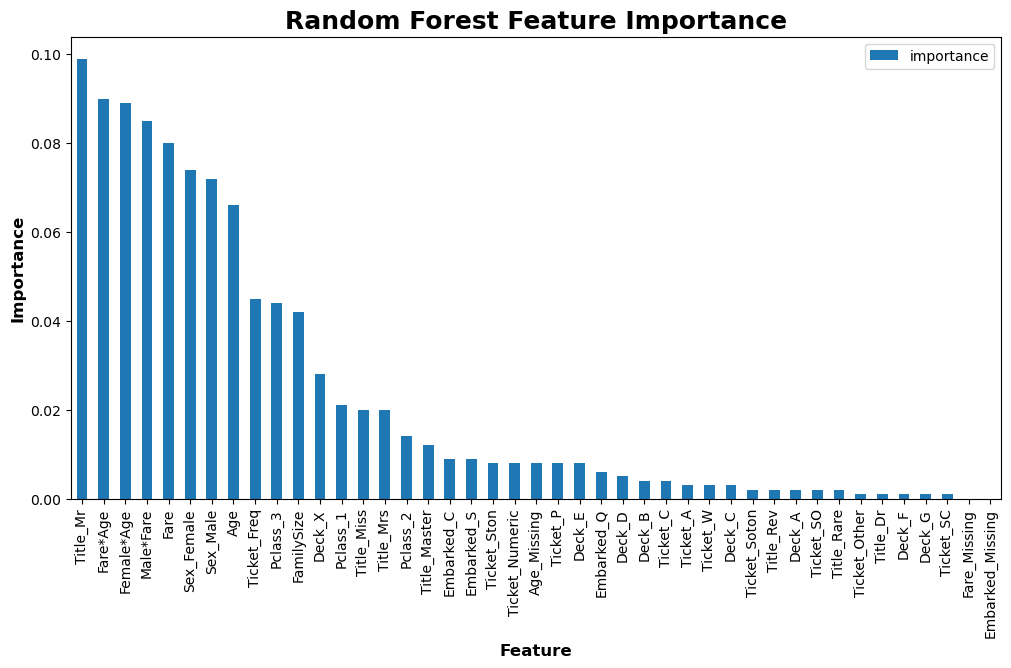

In [75]:
rf_feature_imp = pd.DataFrame({'feature': X_train.columns, 
                               'importance': np.round(model_dict['Random Forest Hyper Tuned']['Model'].feature_importances_,3)})
rf_feature_imp = rf_feature_imp.sort_values('importance', ascending = False).set_index('feature')

f, ax = plt.subplots(figsize = (12, 6))
rf_feature_imp.plot.bar(ax = ax)
plt.title('Random Forest Feature Importance', fontdict = plot_title_dict)
plt.ylabel('Importance', fontdict = plot_axis_dict)
plt.xlabel('Feature', fontdict = plot_axis_dict)
plt.show()

# 7.2 XGBoost Hyper Parameter Tuning

In [76]:
model_dict['XGBoost Hyper Tuned'] = {'X_Train': X_train_scaled, 'X_Test': X_test_scaled}

In [77]:
def xgb_obj_fun(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0, 5),
    }
    
    model = xgb.XGBClassifier(**param)
    score = cross_val_score(model, 
                            model_dict['XGBoost Hyper Tuned']['X_Train'], 
                            Y_train, cv = 3, 
                            scoring = "roc_auc").mean()
    return score

xgb_study = optuna.create_study(study_name = 'xgboost_study_cpu', direction = "maximize")
xgb_study.optimize(xgb_obj_fun,
                   n_trials = 10,
                   show_progress_bar = True,
                   n_jobs = -1)

[I 2025-11-28 23:45:41,423] A new study created in memory with name: xgboost_study_cpu
Best trial: 3. Best value: 0.872368:  10%|▋      | 1/10 [00:10<01:31, 10.20s/it]

[I 2025-11-28 23:45:51,628] Trial 3 finished with value: 0.872367622151919 and parameters: {'max_depth': 5, 'learning_rate': 0.07813810835728915, 'n_estimators': 156, 'subsample': 0.5635926069261057, 'colsample_bytree': 0.5162837828216601, 'min_child_weight': 3, 'gamma': 3.410670337145193}. Best is trial 3 with value: 0.872367622151919.


Best trial: 1. Best value: 0.875787:  20%|█▍     | 2/10 [00:10<00:37,  4.65s/it]

[I 2025-11-28 23:45:52,384] Trial 1 finished with value: 0.8757869172019301 and parameters: {'max_depth': 5, 'learning_rate': 0.05789831916693619, 'n_estimators': 118, 'subsample': 0.8612716778420515, 'colsample_bytree': 0.9113144423461048, 'min_child_weight': 5, 'gamma': 2.2515811653505247}. Best is trial 1 with value: 0.8757869172019301.


Best trial: 1. Best value: 0.875787:  30%|██     | 3/10 [00:11<00:18,  2.70s/it]

[I 2025-11-28 23:45:52,758] Trial 7 finished with value: 0.8691160962515578 and parameters: {'max_depth': 7, 'learning_rate': 0.05307065060286985, 'n_estimators': 198, 'subsample': 0.9080196095231909, 'colsample_bytree': 0.689538103937053, 'min_child_weight': 4, 'gamma': 4.042131510000254}. Best is trial 1 with value: 0.8757869172019301.


Best trial: 1. Best value: 0.875787:  40%|██▊    | 4/10 [00:12<00:12,  2.08s/it]

[I 2025-11-28 23:45:53,902] Trial 2 finished with value: 0.8757070271306682 and parameters: {'max_depth': 9, 'learning_rate': 0.09324781960507636, 'n_estimators': 286, 'subsample': 0.752483850286439, 'colsample_bytree': 0.9811127240261213, 'min_child_weight': 6, 'gamma': 2.7868051409102974}. Best is trial 1 with value: 0.8757869172019301.


Best trial: 0. Best value: 0.87808:  50%|████    | 5/10 [00:13<00:08,  1.66s/it]

[I 2025-11-28 23:45:54,814] Trial 0 finished with value: 0.878079762247148 and parameters: {'max_depth': 6, 'learning_rate': 0.08773017834221385, 'n_estimators': 195, 'subsample': 0.6427307762494522, 'colsample_bytree': 0.8279853728214763, 'min_child_weight': 4, 'gamma': 1.5099523993377328}. Best is trial 0 with value: 0.878079762247148.


Best trial: 0. Best value: 0.87808:  60%|████▊   | 6/10 [00:13<00:05,  1.26s/it]

[I 2025-11-28 23:45:55,307] Trial 4 finished with value: 0.8684050746173265 and parameters: {'max_depth': 4, 'learning_rate': 0.055810951533287315, 'n_estimators': 465, 'subsample': 0.9046572100488165, 'colsample_bytree': 0.6362402357270251, 'min_child_weight': 7, 'gamma': 3.37827613845229}. Best is trial 0 with value: 0.878079762247148.


Best trial: 0. Best value: 0.87808:  70%|█████▌  | 7/10 [00:14<00:02,  1.09it/s]

[I 2025-11-28 23:45:55,519] Trial 5 finished with value: 0.8761863675582399 and parameters: {'max_depth': 9, 'learning_rate': 0.024301901268677956, 'n_estimators': 261, 'subsample': 0.8177767985439186, 'colsample_bytree': 0.6945329050117685, 'min_child_weight': 1, 'gamma': 2.9617671485960355}. Best is trial 0 with value: 0.878079762247148.


Best trial: 0. Best value: 0.87808:  80%|██████▍ | 8/10 [00:14<00:01,  1.27it/s]

[I 2025-11-28 23:45:56,026] Trial 8 finished with value: 0.8701706451922155 and parameters: {'max_depth': 3, 'learning_rate': 0.011620545483021124, 'n_estimators': 364, 'subsample': 0.8185140009264009, 'colsample_bytree': 0.8338872924289924, 'min_child_weight': 3, 'gamma': 4.23748300604455}. Best is trial 0 with value: 0.878079762247148.


Best trial: 0. Best value: 0.87808: 100%|███████| 10/10 [00:15<00:00,  1.60s/it]

[I 2025-11-28 23:45:57,392] Trial 6 finished with value: 0.8757949062090563 and parameters: {'max_depth': 9, 'learning_rate': 0.022925754730744333, 'n_estimators': 830, 'subsample': 0.7486095048675732, 'colsample_bytree': 0.8400848291024487, 'min_child_weight': 5, 'gamma': 2.4353445257705486}. Best is trial 0 with value: 0.878079762247148.
[I 2025-11-28 23:45:57,401] Trial 9 finished with value: 0.8721039849167546 and parameters: {'max_depth': 3, 'learning_rate': 0.013062732039216311, 'n_estimators': 963, 'subsample': 0.7782943183883193, 'colsample_bytree': 0.6338331234456873, 'min_child_weight': 3, 'gamma': 4.22950537948542}. Best is trial 0 with value: 0.878079762247148.


In [78]:
xgb_best_params = xgb_study.best_params
print(f"\nBest parameters: {xgb_best_params}")


Best parameters: {'max_depth': 6, 'learning_rate': 0.08773017834221385, 'n_estimators': 195, 'subsample': 0.6427307762494522, 'colsample_bytree': 0.8279853728214763, 'min_child_weight': 4, 'gamma': 1.5099523993377328}


In [79]:
xgb_tuned = XGBClassifier(n_estimators = xgb_best_params['n_estimators'],
                          max_depth = xgb_best_params['max_depth'],
                          learning_rate = xgb_best_params['learning_rate'],
                          subsample = xgb_best_params['subsample'],
                          colsample_bytree = xgb_best_params['colsample_bytree'],
                          min_child_weight = xgb_best_params['min_child_weight'],
                          gamma = xgb_best_params['gamma'])
xgb_tuned.fit(model_dict['XGBoost Hyper Tuned']['X_Train'], Y_train)
model_dict['XGBoost Hyper Tuned']['Model'] = xgb_tuned

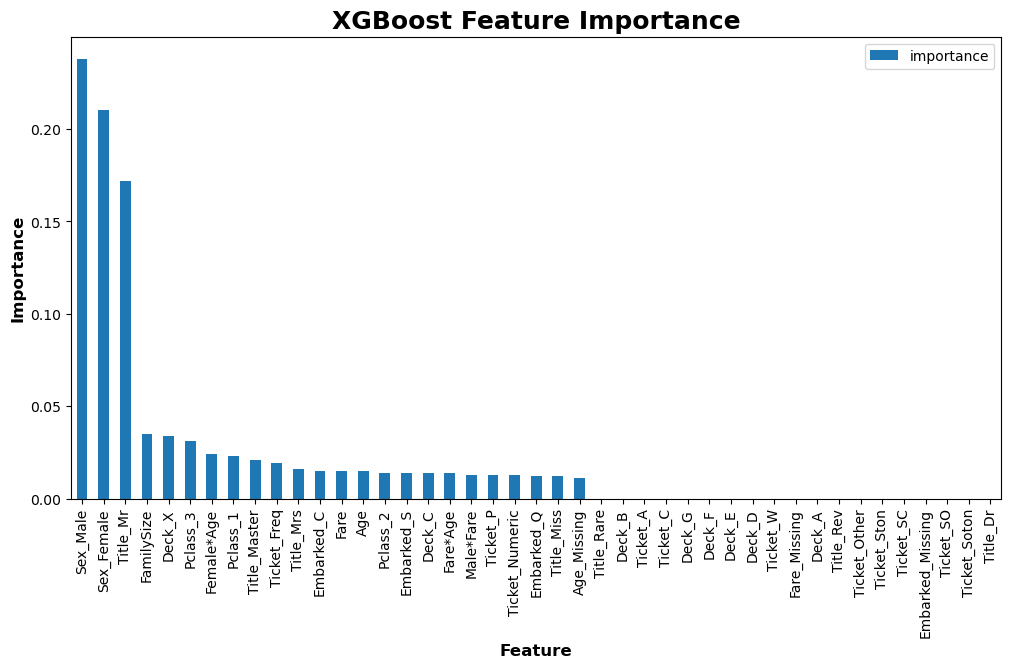

In [80]:
xgb_feature_imp = pd.DataFrame({'feature': X_train.columns, 
                                'importance': np.round(model_dict['XGBoost Hyper Tuned']['Model'].feature_importances_,3)})
xgb_feature_imp = xgb_feature_imp.sort_values('importance', ascending = False).set_index('feature')

f, ax = plt.subplots(figsize = (12, 6))
xgb_feature_imp.plot.bar(ax = ax)
plt.title('XGBoost Feature Importance', fontdict = plot_title_dict)
plt.ylabel('Importance', fontdict = plot_axis_dict)
plt.xlabel('Feature', fontdict = plot_axis_dict)
plt.show()

# 8. Calculate Model Probabilities

1. Narrow down initial list of models with best candidates
2. Calculate and store model probabilities
3. Evaluate Metrics

Metrics:
1. Confusion Matrix
2. Precision and Recall
3. F1 Score
4. ROC AUC Curve and Score

In [81]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, roc_curve, roc_auc_score

In [82]:
final_options = ['Logistic Regression',
                 'Support Vector Machines',
                 'Random Forest Hyper Tuned',
                 'XGBoost Hyper Tuned']

for final_model in final_options:
    model_dict[final_model]['CV_Prob'] = cross_val_predict(model_dict[final_model]['Model'],
                                                           model_dict[final_model]['X_Train'],
                                                           Y_train,
                                                           cv = 10,
                                                           method = 'predict_proba')[:,1]
    model_dict[final_model]['Train_Prob'] = model_dict[final_model]['Model'].predict_proba(model_dict[final_model]['X_Train'])[:,1]
    model_dict[final_model]['Test_Prob'] = model_dict[final_model]['Model'].predict_proba(model_dict[final_model]['X_Test'])[:,1]

In [83]:
final_metrics_df = pd.DataFrame()
fpr_list = []
tpr_list = []
conf_mat_list = []
roc_auc_list = []
for final_model in final_options:
    
    # Confusion Matrix
    cv_preds = [int(float(p) > 0.5) for p in model_dict[final_model]['CV_Prob']]
    model_confusion_matrix = confusion_matrix(Y_train, cv_preds)
    conf_mat_list.append(model_confusion_matrix)
    true_non_surv = model_confusion_matrix[0][0]
    true_surv = model_confusion_matrix[1][1]

    # ROC Curve
    y_train_prob = model_dict[final_model]['Train_Prob']
    model_fpr, model_tpr, model_thresholds = roc_curve(Y_train, y_train_prob)
    fpr_list.append(model_fpr)
    tpr_list.append(model_tpr)
    model_roc_auc = roc_auc_score(Y_train, y_train_prob)
    roc_auc_list.append(model_roc_auc)

    # Metrics
    model_precision = precision_score(Y_train, cv_preds)
    model_recall = recall_score(Y_train, cv_preds)
    model_f1 = f1_score(Y_train, cv_preds)

    final_metrics_df = pd.concat([final_metrics_df,
                                  pd.DataFrame({'Selected Model': [final_model],
                                                'Precision': [round(model_precision * 100, 2)],
                                                'Recall': [round(model_recall * 100, 2)],
                                                'F1 Score': [round(model_f1 * 100, 2)],
                                                'ROC AUC': [round(model_roc_auc * 100, 2)], 
                                                'Non Survivors': true_non_surv,
                                                'Survivors': true_surv,
                                                'Total Correct': true_non_surv + true_surv
                                               })]).reset_index(drop = True)
final_metrics_df.sort_values(by = 'Precision', ascending = False)

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
1,Support Vector Machines,83.68,70.47,76.51,91.44,502,241,743
2,Random Forest Hyper Tuned,81.97,73.10,77.28,97.72,494,250,744
3,XGBoost Hyper Tuned,81.55,73.68,77.42,95.16,492,252,744
0,Logistic Regression,80.57,73.98,77.13,89.29,488,253,741


# 9. Create Ensemble Models

SVC good at predicting true non survivors, but other models good at predicting survivors. Explore ensembles

Cannot include Perceptron, Linear SVC, Stochastic Gradient Decent

In [84]:
ensemble1_name = 'Ensemble: SVC + XGBoost Tuned'
ensemble1 = ['Support Vector Machines', 'XGBoost Hyper Tuned']
ensemble1_cv_prob = []
ensemble1_train_prob = []
ensemble1_test_prob = []
for m in ensemble1:
    ensemble1_cv_prob.append(model_dict[m]['CV_Prob'])
    ensemble1_train_prob.append(model_dict[m]['Train_Prob'])
    ensemble1_test_prob.append(model_dict[m]['Test_Prob'])
model_dict[ensemble1_name] = {'CV_Prob': np.mean(ensemble1_cv_prob, axis = 0),
                              'Train_Prob': np.mean(ensemble1_train_prob, axis = 0),
                              'Test_Prob': np.mean(ensemble1_test_prob, axis = 0)}
final_options = final_options + [ensemble1_name]

In [85]:
ensemble2_name = 'Ensemble: SVC + Random Forest Tuned'
ensemble2 = ['Support Vector Machines', 'Random Forest Hyper Tuned']
ensemble2_cv_prob = []
ensemble2_train_prob = []
ensemble2_test_prob = []
for m in ensemble2:
    ensemble2_cv_prob.append(model_dict[m]['CV_Prob'])
    ensemble2_train_prob.append(model_dict[m]['Train_Prob'])
    ensemble2_test_prob.append(model_dict[m]['Test_Prob'])
model_dict[ensemble2_name] = {'CV_Prob': np.mean(ensemble2_cv_prob, axis = 0),
                              'Train_Prob': np.mean(ensemble2_train_prob, axis = 0),
                              'Test_Prob': np.mean(ensemble2_test_prob, axis = 0)}
final_options = final_options + [ensemble2_name]

In [86]:
ensemble3_name = 'Ensemble: SVC + RF Tuned + XGBoost Tuned'
ensemble3 = ['Support Vector Machines', 'Random Forest Hyper Tuned', 'XGBoost Hyper Tuned']
ensemble3_cv_prob = []
ensemble3_train_prob = []
ensemble3_test_prob = []
for m in ensemble3:
    ensemble3_cv_prob.append(model_dict[m]['CV_Prob'])
    ensemble3_train_prob.append(model_dict[m]['Train_Prob'])
    ensemble3_test_prob.append(model_dict[m]['Test_Prob'])
model_dict[ensemble3_name] = {'CV_Prob': np.mean(ensemble3_cv_prob, axis = 0),
                              'Train_Prob': np.mean(ensemble3_train_prob, axis = 0),
                              'Test_Prob': np.mean(ensemble3_test_prob, axis = 0)}
final_options = final_options + [ensemble3_name]

In [87]:
ensemble4_name = 'Ensemble: SVC + Logistic Regression'
ensemble4 = ['Support Vector Machines', 'Logistic Regression']
ensemble4_cv_prob = []
ensemble4_train_prob = []
ensemble4_test_prob = []
for m in ensemble3:
    ensemble4_cv_prob.append(model_dict[m]['CV_Prob'])
    ensemble4_train_prob.append(model_dict[m]['Train_Prob'])
    ensemble4_test_prob.append(model_dict[m]['Test_Prob'])
model_dict[ensemble4_name] = {'CV_Prob': np.mean(ensemble4_cv_prob, axis = 0),
                              'Train_Prob': np.mean(ensemble4_train_prob, axis = 0),
                              'Test_Prob': np.mean(ensemble4_test_prob, axis = 0)}
final_options = final_options + [ensemble4_name]

In [88]:
ensemble5_name = 'Ensemble: SVC + Random Forest (Base)'
ensemble5 = ['Support Vector Machines', 'Random Forest']
ensemble5_cv_prob = []
ensemble5_train_prob = []
ensemble5_test_prob = []
for m in ensemble5:
    ensemble5_cv_prob.append(model_dict[m]['CV_Prob'])
    ensemble5_train_prob.append(model_dict[m]['Train_Prob'])
    ensemble5_test_prob.append(model_dict[m]['Test_Prob'])
model_dict[ensemble5_name] = {'CV_Prob': np.mean(ensemble5_cv_prob, axis = 0),
                              'Train_Prob': np.mean(ensemble5_train_prob, axis = 0),
                              'Test_Prob': np.mean(ensemble5_test_prob, axis = 0)}
final_options = final_options + [ensemble5_name]

In [89]:
final_options

['Logistic Regression',
 'Support Vector Machines',
 'Random Forest Hyper Tuned',
 'XGBoost Hyper Tuned',
 'Ensemble: SVC + XGBoost Tuned',
 'Ensemble: SVC + Random Forest Tuned',
 'Ensemble: SVC + RF Tuned + XGBoost Tuned',
 'Ensemble: SVC + Logistic Regression',
 'Ensemble: SVC + Random Forest (Base)']

# 10. Calculate Model Performance Metrics

Re-evaluate metrics with ensemble models.

Metrics:
1. Confusion Matrix
2. Precision and Recall
3. F1 Score
4. ROC AUC Curve and Score

In [90]:
final_metrics_df = pd.DataFrame()
fpr_list = []
tpr_list = []
conf_mat_list = []
roc_auc_list = []
for final_model in final_options:
    
    # Confusion Matrix
    cv_preds = [int(float(p) > 0.5) for p in model_dict[final_model]['CV_Prob']]
    model_confusion_matrix = confusion_matrix(Y_train, cv_preds)
    conf_mat_list.append(model_confusion_matrix)
    true_non_surv = model_confusion_matrix[0][0]
    true_surv = model_confusion_matrix[1][1]

    # ROC Curve
    y_train_prob = model_dict[final_model]['Train_Prob']
    model_fpr, model_tpr, model_thresholds = roc_curve(Y_train, y_train_prob)
    fpr_list.append(model_fpr)
    tpr_list.append(model_tpr)
    model_roc_auc = roc_auc_score(Y_train, y_train_prob)
    roc_auc_list.append(model_roc_auc)

    # Metrics
    model_precision = precision_score(Y_train, cv_preds)
    model_recall = recall_score(Y_train, cv_preds)
    model_f1 = f1_score(Y_train, cv_preds)

    final_metrics_df = pd.concat([final_metrics_df,
                                  pd.DataFrame({'Selected Model': [final_model],
                                                'Precision': [round(model_precision * 100, 2)],
                                                'Recall': [round(model_recall * 100, 2)],
                                                'F1 Score': [round(model_f1 * 100, 2)],
                                                'ROC AUC': [round(model_roc_auc * 100, 2)], 
                                                'Non Survivors': true_non_surv,
                                                'Survivors': true_surv,
                                                'Total Correct': true_non_surv + true_surv
                                               })]).reset_index(drop = True)

In [91]:
print('Titanic: 81.1% Leader board Score Guaranteed notebook predicted ' + str(501 + 252))
final_metrics_df.sort_values(by = 'Precision', ascending = False)

Titanic: 81.1% Leader board Score Guaranteed notebook predicted 753


,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
5,Ensemble: SVC + Random Forest Tuned,84.18,73.10,78.25,96.63,502,250,752
1,Support Vector Machines,83.68,70.47,76.51,91.44,502,241,743
8,Ensemble: SVC + Random Forest (Base),83.39,73.39,78.07,98.81,499,251,750
4,Ensemble: SVC + XGBoost Tuned,83.33,73.10,77.88,94.82,499,250,749
6,Ensemble: SVC + RF Tuned + XGBoost Tuned,82.89,73.68,78.02,96.42,497,252,749
7,Ensemble: SVC + Logistic Regression,82.89,73.68,78.02,96.42,497,252,749
2,Random Forest Hyper Tuned,81.97,73.10,77.28,97.72,494,250,744
3,XGBoost Hyper Tuned,81.55,73.68,77.42,95.16,492,252,744
0,Logistic Regression,80.57,73.98,77.13,89.29,488,253,741


In [92]:
pd.read_pickle('data/final_metrics').sort_values(by = 'Precision', ascending = False)

# # Save for comp
# final_metrics_df.to_pickle('data/final_metrics')

,Selected Model,Precision,Recall,F1 Score,ROC AUC,Non Survivors,Survivors,Total Correct
1,Support Vector Machines,83.10,70.47,76.27,91.38,500,241,741
2,Random Forest Hyper Tuned,81.25,72.22,76.47,92.42,492,247,739
3,XGBoost Hyper Tuned,79.50,74.85,77.11,95.56,483,256,739
0,Logistic Regression,79.26,74.85,76.99,89.18,482,256,738


# 11. Select Final Model

Combining SVC and Random Forest scores highest across both precision and recall and also has the highest F1 score.

In [93]:
selection = 5

final_model = final_options[selection]
print('Selected Model: ' + final_model)
Y_test_prob = model_dict[final_model]['Test_Prob']
submission_df = pd.DataFrame({"PassengerId": test_df["PassengerId"],
                              "Survived": [int(float(p) > 0.5) for p in Y_test_prob]})
submission_df.to_csv('/Users/andressanchez/Documents/DataScience/Titanic/results/submission.csv', index = False)
submission_df

Selected Model: Ensemble: SVC + Random Forest Tuned


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


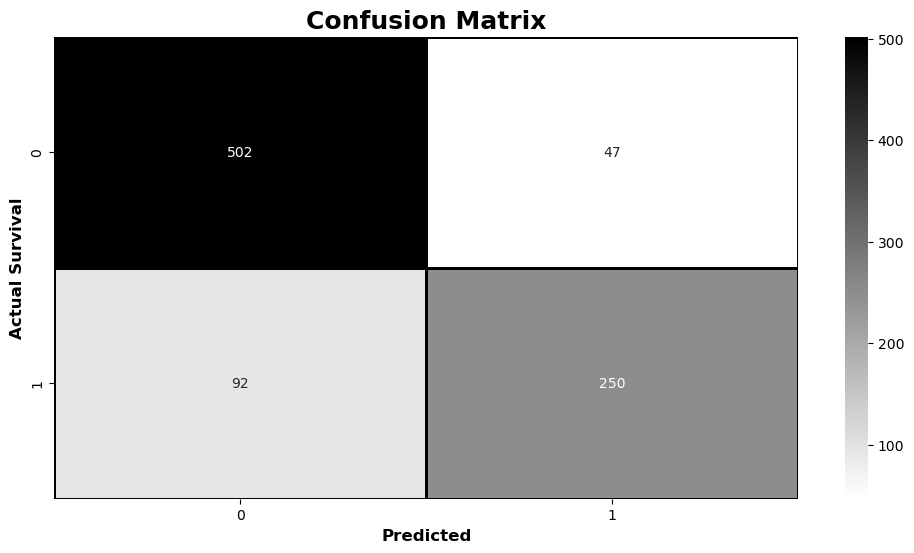

In [94]:
f, ax = plt.subplots(figsize = (12, 6))

sns.heatmap(conf_mat_list[selection],
            annot = True,
            fmt = ',.0f',
            cmap = 'binary',
            linewidths = 1, 
            linecolor = 'black',
            cbar_kws = {'format': mtick.StrMethodFormatter('{x:,.0f}')},
            ax = ax)
plt.title('Confusion Matrix', fontdict = plot_title_dict)
plt.ylabel('Actual Survival', fontdict = plot_axis_dict)
plt.xlabel('Predicted', fontdict = plot_axis_dict)
plt.show()

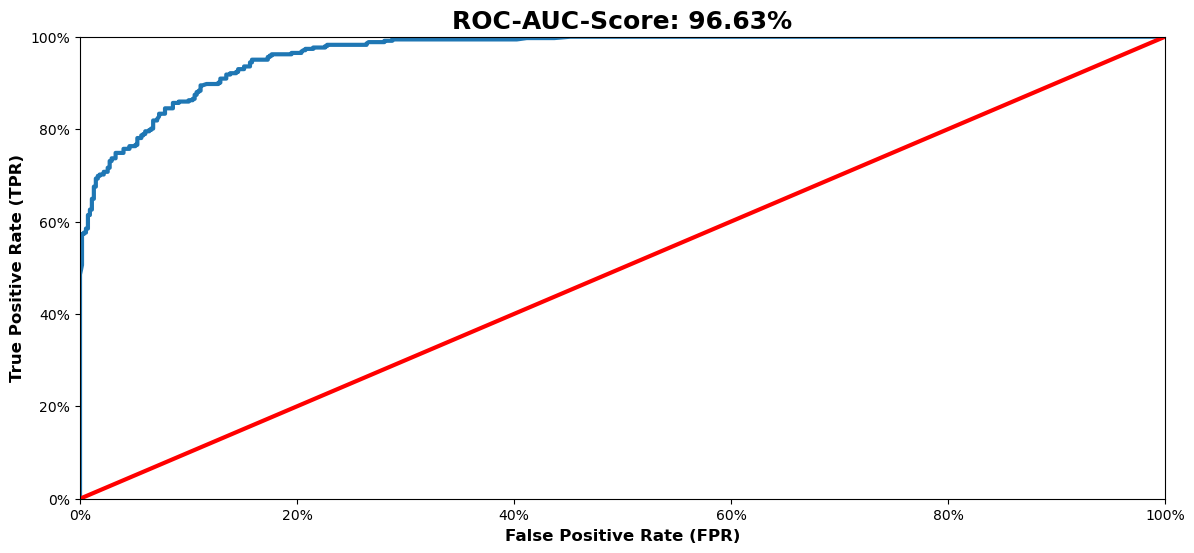

In [95]:
f, ax = plt.subplots(figsize = (14, 6))
plt.plot(fpr_list[selection], 
         tpr_list[selection], 
         linewidth = 3, label = None)
plt.plot([0, 1], [0, 1], 'r', linewidth = 3)
plt.axis([0, 1, 0, 1])
plt.title('ROC-AUC-Score: ' +"{:.2%}".format(roc_auc_list[selection]), fontdict = plot_title_dict)
plt.xlabel('False Positive Rate (FPR)', fontdict = plot_axis_dict)
plt.ylabel('True Positive Rate (TPR)', fontdict = plot_axis_dict)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.show()

# 12. Submit to Kaggle

References:
1. https://www.kaggle.com/docs/api
2. https://www.youtube.com/watch?v=gkEbaMgvLs8

In [ ]:
print('Selected Model: ' + final_model)
print('Make sure to update comment on submission')

In [ ]:
# !kaggle competitions submit -c titanic -f results/submission.csv -m svc_rft

# 13. Compare Public Score with Leaderboard

Models:
1. Support Vector Machines Public Score: **0.79186**
2. Random Forest Hyper Tuned Public Score: **0.78229**
3. XGB Hyper Tuned Public Score: **0.76794**
3. Logistic Regression Public Score: **0.76794** scaled, **0.77033** unscaled

In [ ]:
# public_score = 0.79186

# scores_df = pd.read_csv('data/titanic-publicleaderboard-2025-11-28T01-56-53.csv')
# scores_df = scores_df[(scores_df['Score'] >= 0.70) & (scores_df['Score'] <= 0.85)].reset_index(drop = True)

# total_scores = scores_df.shape[0]
# better_scores = scores_df[scores_df['Score'] > public_score].shape[0]
# worse_scores = scores_df[scores_df['Score'] <= public_score].shape[0]
# score_pct = better_scores / total_scores

# print('Public score: ' + "{:.3%}".format(public_score))
# print('Mean score: ' + "{:.3%}".format(scores_df['Score'].mean()))
# print('Median score: ' + "{:.3%}".format(scores_df['Score'].median()))
# print("{:.1%}".format(better_scores / total_scores) + ' are better')
# print("{:.1%}".format(worse_scores / total_scores) + ' are equal or worse')
# print('Out of ' + "{:,}".format(total_scores) + ' scores, ' + "{:,}".format(better_scores) + ' scored higher.')

# sns.displot(data = scores_df, 
#             x = 'Score', 
#             kde = True,
#             height = 5,
#             aspect = 2)
# plt.axvline(x = public_score, color = 'red')
# plt.suptitle('Distribution of Kaggle Public Scores')
# plt.show()